# **HIPOTESIS 1**

H1. Los hombres consumen más estupefacientes que las mujeres en todos los grupos de edad y en todos los paises

📌 Problema que se aborda: diferencia de la prevalencia de consumo por grupo de edad, por género y por tipo de estupefaciente

Análisis que hacemos: cantidad qu consumen hombrees y mujeres, cantidad que consumen por grupo de edad, relaciones entre consumo y genero, relacion entre consumo y grupo de edad, analisis de que tipo de droga consumen mas por genero y que tipo de droga consumen mas por edad

In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats

In [56]:
df_drugs = pd.read_csv("../data/data_clean/drugs.csv", index_col=0)
df_drugs_no_na = pd.read_csv("../data/data_clean/drugs_no_na.csv", index_col=0)

In [57]:
df_drugs

country  survey_year  prevalence_(%) substance recall_period  \
0     Austria         2020            22.7  Cannabis      Lifetime   
1     Austria         2020            27.2  Cannabis      Lifetime   
2     Austria         2020             6.3  Cannabis     Last year   
3     Austria         2020            11.1  Cannabis     Last year   
4     Austria         2020             3.6  Cannabis    Last month   
...       ...          ...             ...       ...           ...   
1038  Türkiye         2017            47.0   Tobacco      Lifetime   
1039  Türkiye         2017            33.4   Tobacco     Last year   
1040  Türkiye         2017            33.2   Tobacco     Last year   
1041  Türkiye         2017            31.5   Tobacco    Last month   
1042  Türkiye         2017            31.2   Tobacco    Last month   

                       age  sample_size  males_(%)  females_(%)  gender_gap  
0           Adults (15-64)       4650.0       24.8         20.6         4.2  
1     Young adults (15-34)       1712.0       26.8         27.6        -0.8  
2           Adults (15-64)       4650.0        6.8          5.8         1.0  
3     Young adults (15-34)       1712.0       10.7         11.4        -0.7  
4           Adults (15-64)       4650.0        4.0          3.1         0.9  
...                    ...          ...        ...          ...         ...  
1038  Young adults (15-34)          NaN       61.9         33.2        28.7  
1039        Adults (15-64)          NaN       45.0         22.5        22.5  
1040  Young adults (15-34)          NaN       45.4         20.6        24.8  
1041        Adults (15-64)          NaN       42.8         21.0        21.8  
1042  Young adults (15-34)          NaN       43.1         18.9        24.2  

[1043 rows x 10 columns]

### ESCONDER - son las funciones de base

In [71]:
# ===================
# Funciones que voy a usar para análisis univariante
# las pongo colapsadas para que no ocupen mucho
# ===================

# Función que calcula la cardinalidad y el tipo de variable
def cardinalidad(df_in, umbral_categoria = 10, umbral_continua = 30):

    resultado = []
    for col in df_in.columns:
        card = df_in[col].nunique()
        porc_card = df_in[col].nunique()/len(df_in) * 100
        tipo = df_in[col].dtypes
        if card == 2:
            clasif = "Binaria"
        elif card < umbral_categoria:
            clasif = "Categórica"
        elif card >= umbral_categoria:
            if porc_card >= umbral_continua:
                clasif = "Numérica Continua"
            else:
                clasif = "Numérica Discreta"

        # Añadimos los resultados a la lista
        resultado.append({
            "columna": col,
            "tipo": tipo,
            "cardinalidad": card,
            "porcentaje_card": porc_card,
            "clasificacion": clasif
        })
    
    # Convertimos la lista de dicts en dataframe
    df_resul = pd.DataFrame(resultado)
        
    return df_resul

# 3. Función que representa las frecuencias absolutas o relativas en gráficos
def pinta_distribucion_categoricas(df, columnas_categoricas, relativa=False, mostrar_valores=False):
    num_columnas = len(columnas_categoricas)
    num_filas = (num_columnas // 2) + (num_columnas % 2)

    fig, axes = plt.subplots(num_filas, 2, figsize=(15, 5 * num_filas))
    axes = axes.flatten() 

    for i, col in enumerate(columnas_categoricas):
        ax = axes[i]
        if relativa:
            total = df[col].value_counts().sum()
            serie = df[col].value_counts().apply(lambda x: x / total)
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia Relativa')
        else:
            serie = df[col].value_counts()
            sns.barplot(x=serie.index, y=serie, ax=ax, palette='viridis', hue = serie.index, legend = False)
            ax.set_ylabel('Frecuencia')

        ax.set_title(f'Distribución de {col}')
        ax.set_xlabel('')
        ax.tick_params(axis='x', rotation=45)

        if mostrar_valores:
            for p in ax.patches:
                height = p.get_height()
                ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height), 
                            ha='center', va='center', xytext=(0, 9), textcoords='offset points')

    for j in range(i + 1, num_filas * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def columnas_numericas(df):
    num_col = df.describe().columns.to_list()
    return num_col

# Función para representar boxplots de columnas numéricas
def plot_multiple_boxplots(df, columns, dim_matriz_visual = 2):
    num_cols = len(columns)
    num_rows = num_cols // dim_matriz_visual + num_cols % dim_matriz_visual
    fig, axes = plt.subplots(num_rows, dim_matriz_visual, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            sns.boxplot(data=df, x=column, ax=axes[i])
            axes[i].set_title(column)

    # Ocultar ejes vacíos
    for j in range(i+1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

def plot_histo_dens(df, columns, bins=None):
    num_cols = len(columns)
    num_rows = num_cols // 2 + num_cols % 2
    fig, axes = plt.subplots(num_rows, 2, figsize=(12, 6 * num_rows))
    axes = axes.flatten()

    for i, column in enumerate(columns):
        if df[column].dtype in ['int64', 'float64']:
            if bins:
                sns.histplot(df[column], kde=True, ax=axes[i], bins=bins)
            else:
                sns.histplot(df[column], kde=True, ax=axes[i])
            axes[i].set_title(f'Histograma y KDE de {column}')

    # Ocultar ejes vacíos
    for j in range(i + 1, num_rows * 2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Función que representa el histograma y el boxplot de varias variables
def plot_combined_graphs(df, columns, whisker_width=1.5):
    num_cols = len(columns)
    if num_cols:
        
        fig, axes = plt.subplots(num_cols, 2, figsize=(12, 5 * num_cols))
        print(axes.shape)

        for i, column in enumerate(columns):
            if df[column].dtype in ['int64', 'float64']:
                # Histograma y KDE
                sns.histplot(df[column], kde=True, ax=axes[i,0] if num_cols > 1 else axes[0])
                if num_cols > 1:
                    axes[i,0].set_title(f'Histograma y KDE de {column}')
                else:
                    axes[0].set_title(f'Histograma y KDE de {column}')

                # Boxplot
                sns.boxplot(x=df[column], ax=axes[i,1] if num_cols > 1 else axes[1], whis=whisker_width)
                if num_cols > 1:
                    axes[i,1].set_title(f'Boxplot de {column}')
                else:
                    axes[1].set_title(f'Boxplot de {column}')

        plt.tight_layout()
        plt.show()

### **ANÁLISIS UNIVARIANTE**

ESTAS FUNCIONES LAS HA HECHO LUCIA:

In [58]:
df_drugs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1043 entries, 0 to 1042
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         1043 non-null   object 
 1   survey_year     1043 non-null   int64  
 2   prevalence_(%)  1043 non-null   float64
 3   substance       1043 non-null   object 
 4   recall_period   1043 non-null   object 
 5   age             1043 non-null   object 
 6   sample_size     950 non-null    float64
 7   males_(%)       1017 non-null   float64
 8   females_(%)     1001 non-null   float64
 9   gender_gap      1001 non-null   float64
dtypes: float64(5), int64(1), object(4)
memory usage: 89.6+ KB


In [59]:
df_drugs.describe()

survey_year  prevalence_(%)   sample_size    males_(%)  females_(%)  \
count  1043.000000     1043.000000    950.000000  1017.000000  1001.000000   
mean   2018.776606       17.558581   4260.586316    19.904621    15.596803   
std       2.174479       26.759251   4568.853108    28.697494    25.437743   
min    2008.000000        0.000000    442.000000     0.000000     0.000000   
25%    2018.000000        0.600000   1572.000000     0.800000     0.300000   
50%    2019.000000        2.800000   2957.000000     3.900000     1.800000   
75%    2020.000000       26.150000   4994.000000    32.000000    21.300000   
max    2022.000000       98.900000  26344.000000    99.600000    98.200000   

        gender_gap  
count  1001.000000  
mean      4.624276  
std       6.281016  
min      -4.000000  
25%       0.400000  
50%       1.900000  
75%       6.600000  
max      38.400000

In [40]:
df_drugs["age"].describe()

count               1043
unique                 2
top       Adults (15-64)
freq                 528
Name: age, dtype: object

In [61]:
categorical_cols = [
    "country",    
    "substance",
    "recall_period",
    "age",
    "males_(%)",
    "females_(%)"
]

In [62]:
#CONTEO DE VALORES ABSOLUTOS
for catego in categorical_cols:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts())
	print("/n"*2)

Para country
country
Austria        42
Bulgaria       42
Croatia        42
Cyprus         42
Germany        42
Portugal       42
Romania        42
Italy          42
Slovakia       42
Ireland        42
Latvia         41
Czechia        40
Lithuania      40
Hungary        38
Finland        38
Türkiye        38
Poland         36
Estonia        36
Spain          36
Luxembourg     36
Netherlands    34
Slovenia       34
Greece         32
Denmark        30
France         30
Norway         30
Sweden         22
Belgium        20
Malta          12
Name: count, dtype: int64
/n/n
Para substance
substance
Cannabis        171
Cocaine         159
Ecstasy         159
Amphetamines    149
LSD             148
Alcohol         132
Tobacco         125
Name: count, dtype: int64
/n/n
Para recall_period
recall_period
Last year     367
Lifetime      348
Last month    328
Name: count, dtype: int64
/n/n
Para age
age
Adults (15-64)          528
Young adults (15-34)    515
Name: count, dtype: int64
/n/n
Para males_(

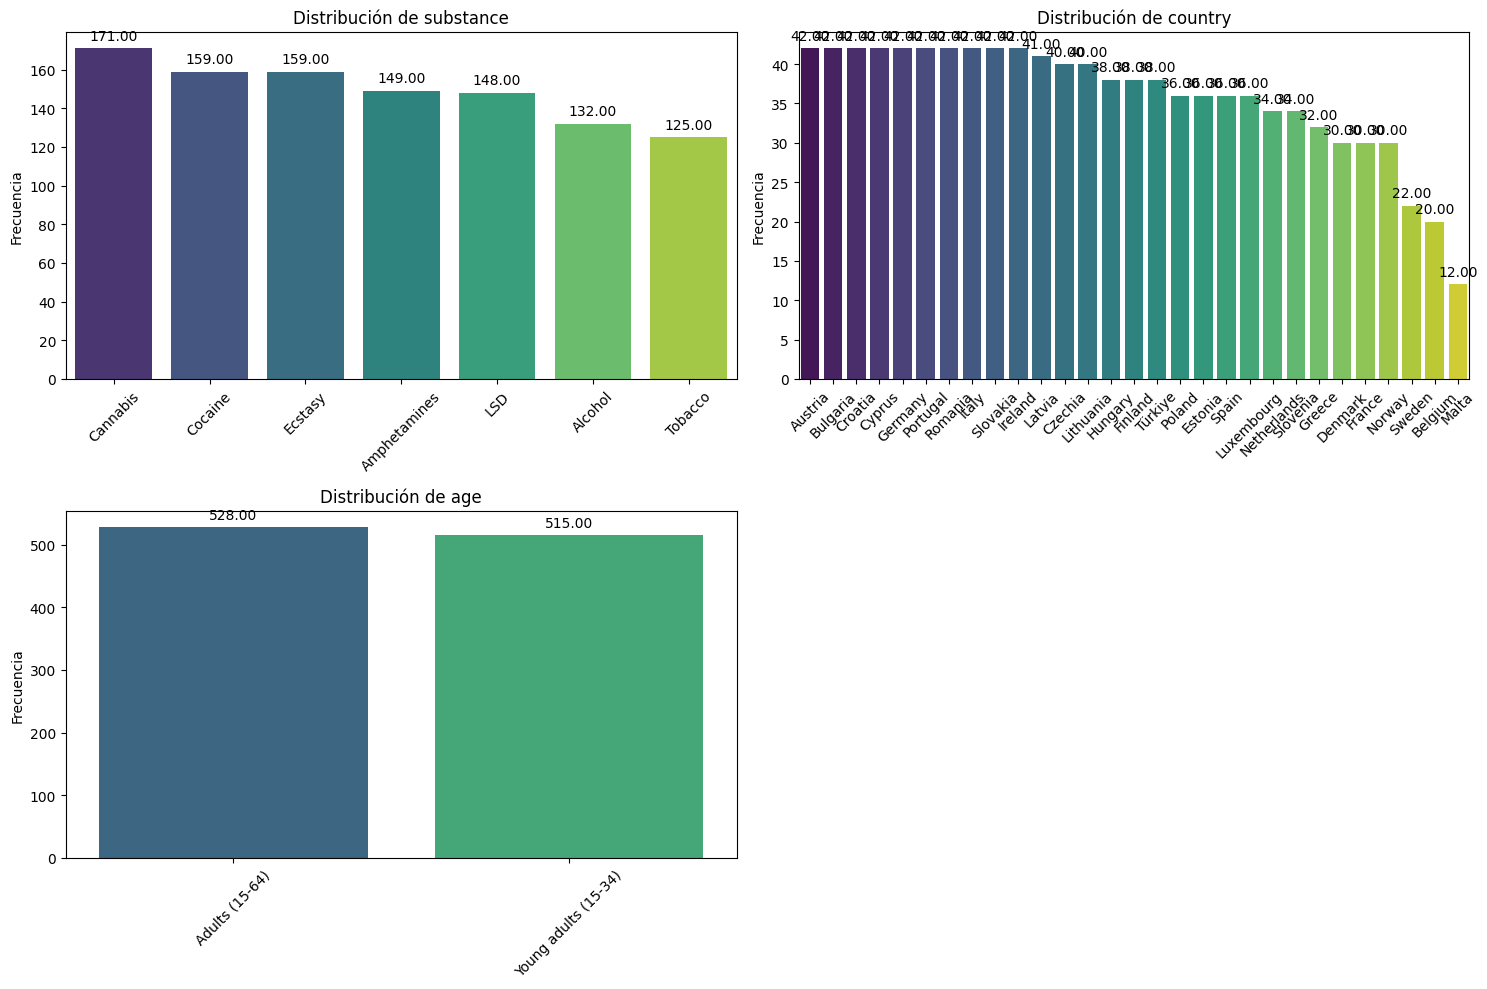

In [63]:
pinta_distribucion_categoricas(df_drugs, ["substance", "country", "age"], relativa=False, mostrar_valores=True)

In [33]:
#VALORES RELATIVOS
for catego in categorical_cols:
	print(f"Para {catego}")
	print(df_drugs[catego].value_counts()/len(df_drugs)*100)
	print("/n"*2)

Para country
country
Austria        4.026846
Bulgaria       4.026846
Croatia        4.026846
Cyprus         4.026846
Germany        4.026846
Portugal       4.026846
Romania        4.026846
Italy          4.026846
Slovakia       4.026846
Ireland        4.026846
Latvia         3.930968
Czechia        3.835091
Lithuania      3.835091
Hungary        3.643337
Finland        3.643337
Türkiye        3.643337
Poland         3.451582
Estonia        3.451582
Spain          3.451582
Luxembourg     3.451582
Netherlands    3.259827
Slovenia       3.259827
Greece         3.068073
Denmark        2.876318
France         2.876318
Norway         2.876318
Sweden         2.109300
Belgium        1.917546
Malta          1.150527
Name: count, dtype: float64
/n/n
Para substance
substance
Cannabis        16.395014
Cocaine         15.244487
Ecstasy         15.244487
Amphetamines    14.285714
LSD             14.189837
Alcohol         12.655801
Tobacco         11.984660
Name: count, dtype: float64
/n/n
Para recal

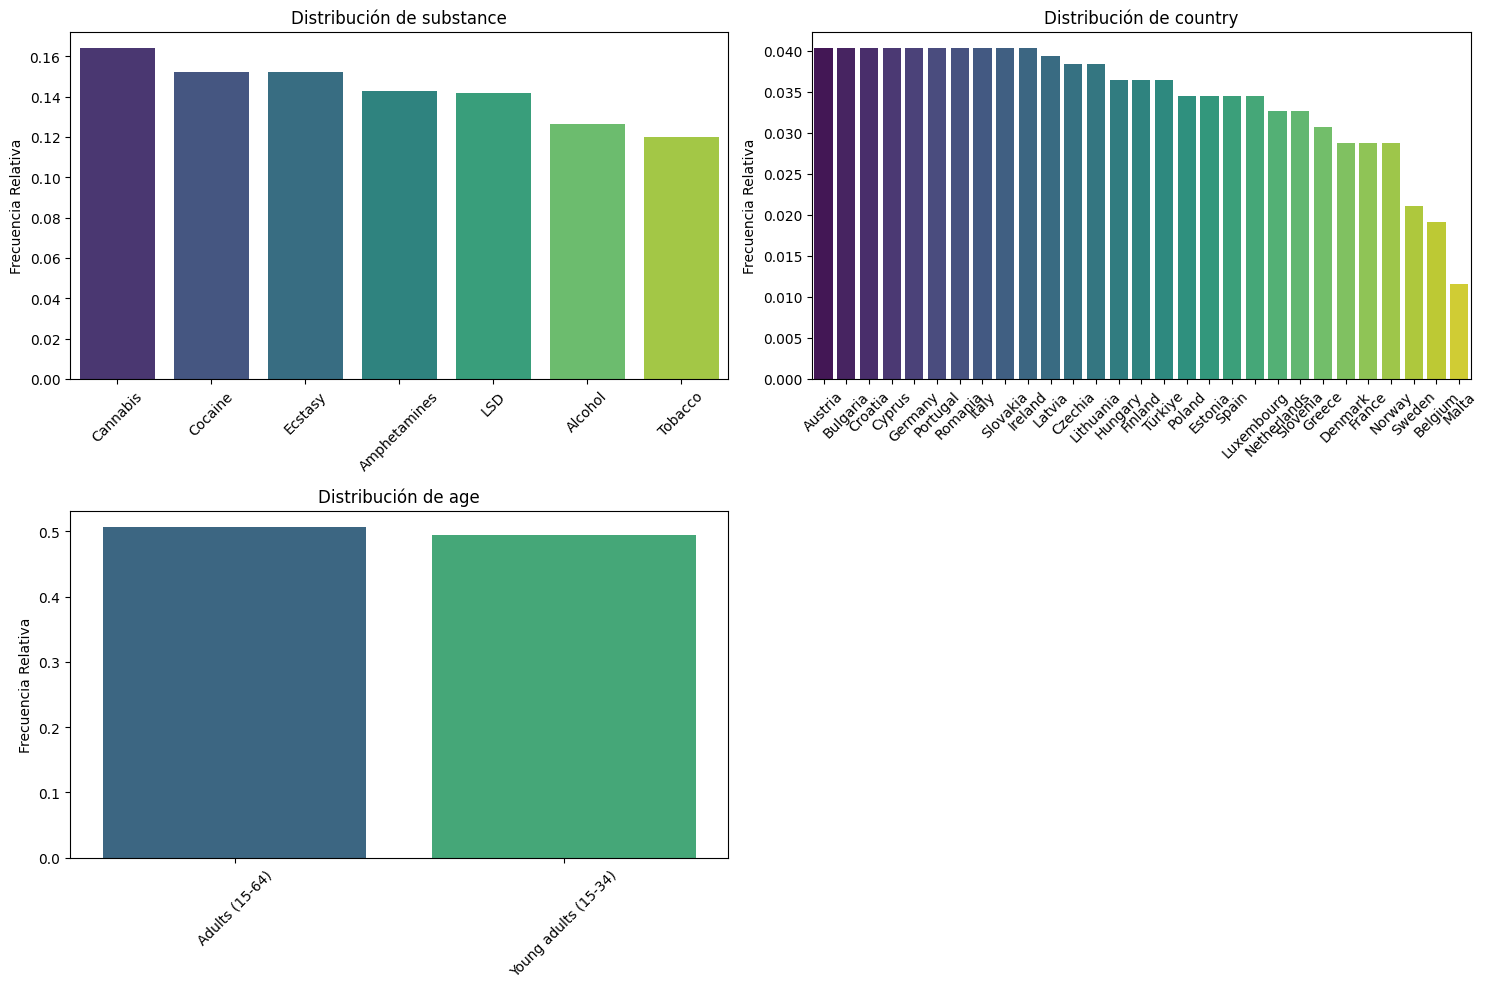

In [36]:
pinta_distribucion_categoricas(df_drugs, ["substance", "country", "age"], relativa=True)

In [16]:
df_drugs

country  survey_year  prevalence_(%) substance recall_period  \
0     Austria         2020            22.7  Cannabis      Lifetime   
1     Austria         2020            27.2  Cannabis      Lifetime   
2     Austria         2020             6.3  Cannabis     Last year   
3     Austria         2020            11.1  Cannabis     Last year   
4     Austria         2020             3.6  Cannabis    Last month   
...       ...          ...             ...       ...           ...   
1038  Türkiye         2017            47.0   Tobacco      Lifetime   
1039  Türkiye         2017            33.4   Tobacco     Last year   
1040  Türkiye         2017            33.2   Tobacco     Last year   
1041  Türkiye         2017            31.5   Tobacco    Last month   
1042  Türkiye         2017            31.2   Tobacco    Last month   

                       age  sample_size  males_(%)  females_(%)  gender_gap  
0           Adults (15-64)       4650.0       24.8         20.6         4.2  
1     Young adults (15-34)       1712.0       26.8         27.6        -0.8  
2           Adults (15-64)       4650.0        6.8          5.8         1.0  
3     Young adults (15-34)       1712.0       10.7         11.4        -0.7  
4           Adults (15-64)       4650.0        4.0          3.1         0.9  
...                    ...          ...        ...          ...         ...  
1038  Young adults (15-34)          NaN       61.9         33.2        28.7  
1039        Adults (15-64)          NaN       45.0         22.5        22.5  
1040  Young adults (15-34)          NaN       45.4         20.6        24.8  
1041        Adults (15-64)          NaN       42.8         21.0        21.8  
1042  Young adults (15-34)          NaN       43.1         18.9        24.2  

[1043 rows x 10 columns]

#### numericas

In [46]:
num_cols = columnas_numericas(df_drugs)
numeric_cols = [
    "prevalence_(%)",
    "males_(%)",
    "females_(%)",
]   

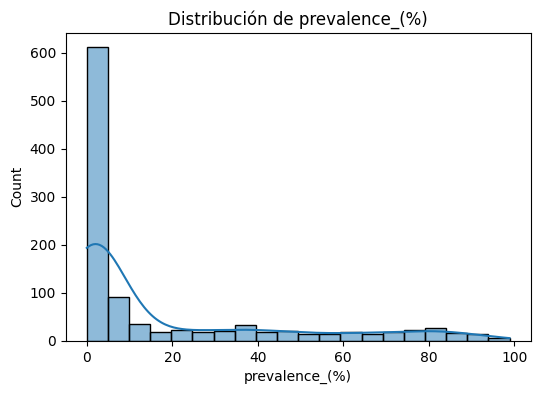

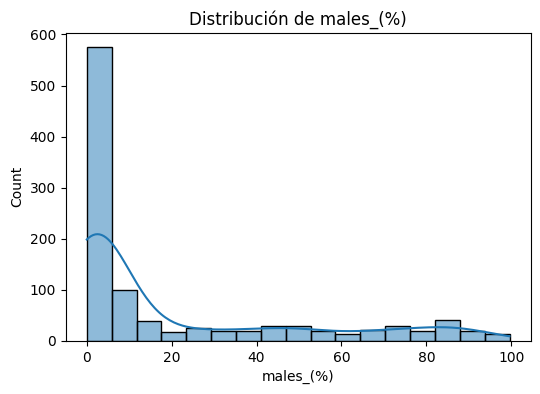

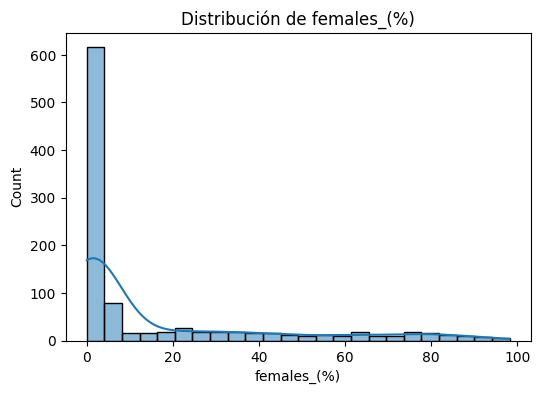

In [47]:
for col in numeric_cols:

    plt.figure(figsize=(6,4))

    sns.histplot(df_drugs[col], kde=True)

    plt.title(f"Distribución de {col}")

    plt.show()

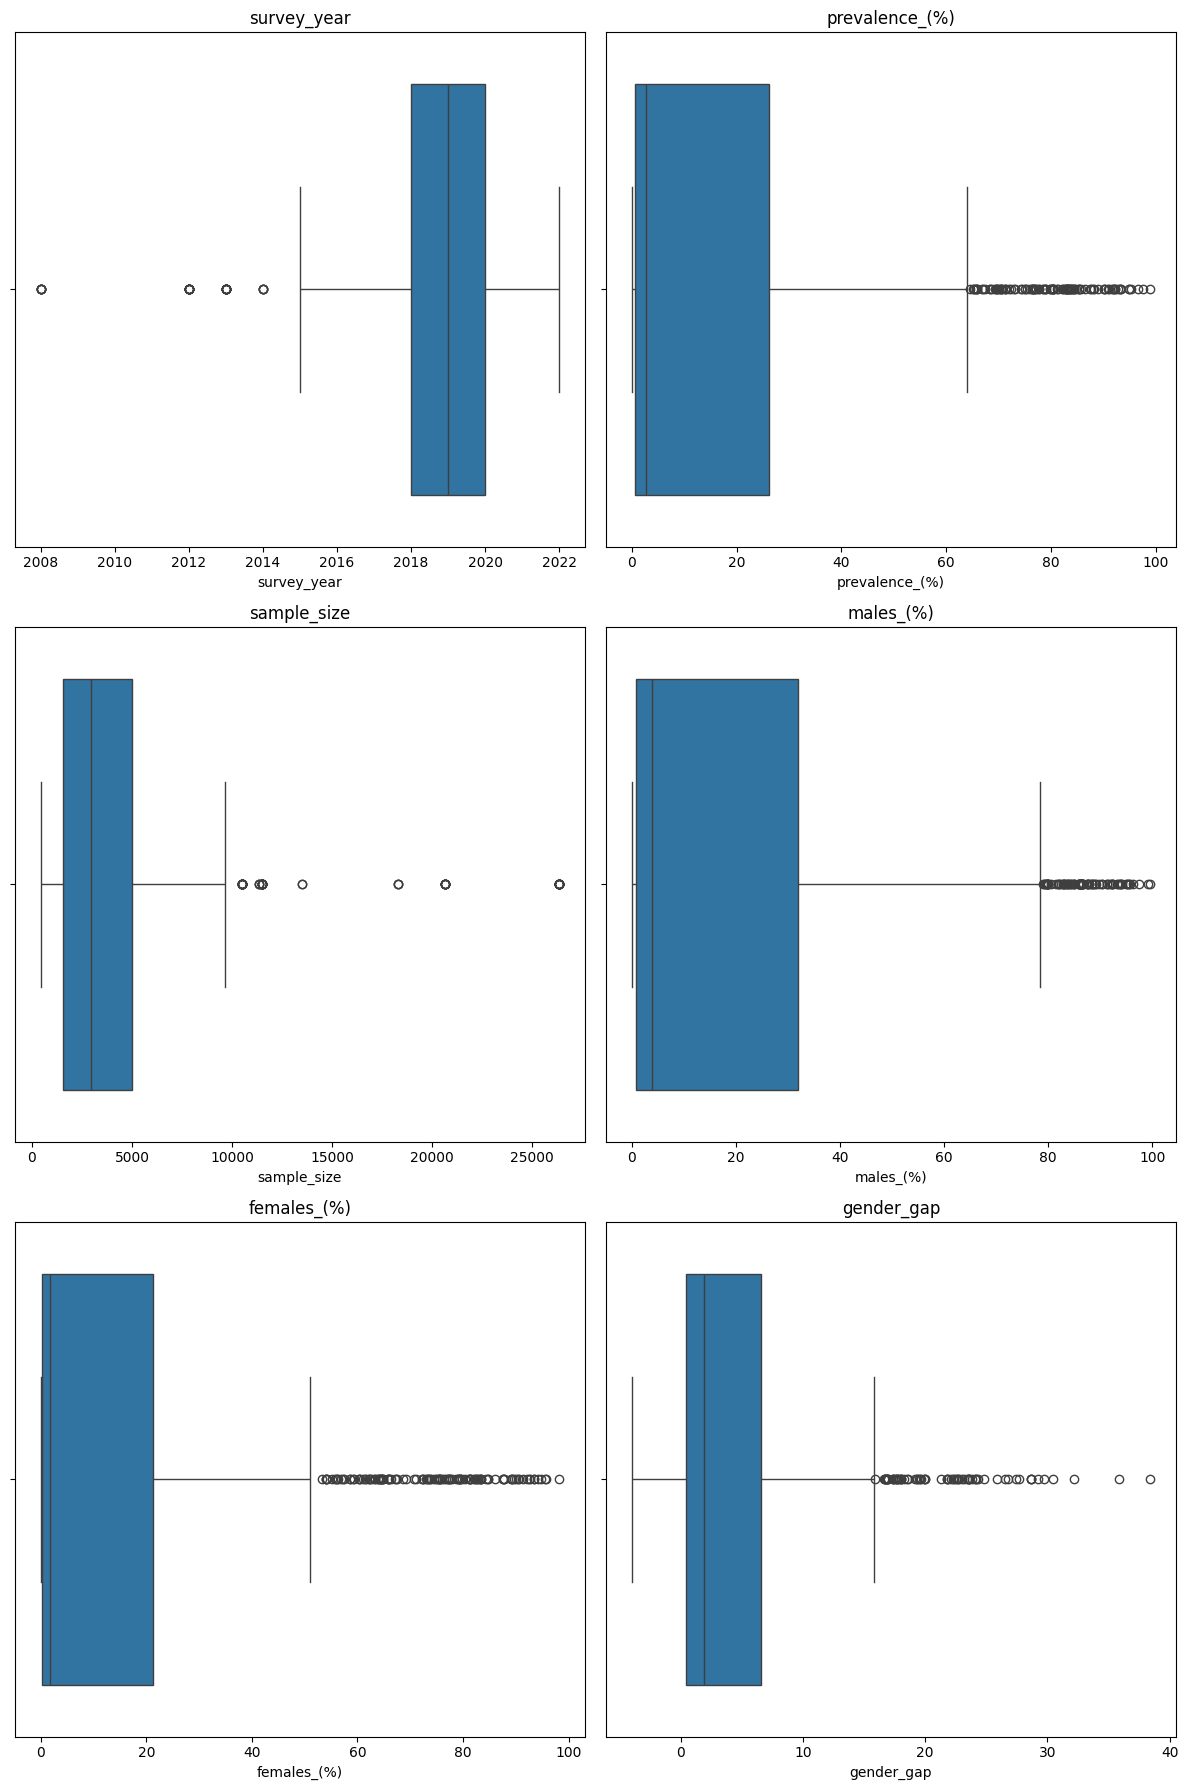

In [69]:
plot_multiple_boxplots(df_drugs, columns=num_cols)

In [49]:
df_drugs.describe().loc["max"] - df_drugs.describe().loc["min"]

survey_year          14.0
prevalence_(%)       98.9
sample_size       25902.0
males_(%)            99.6
females_(%)          98.2
gender_gap           42.4
dtype: float64

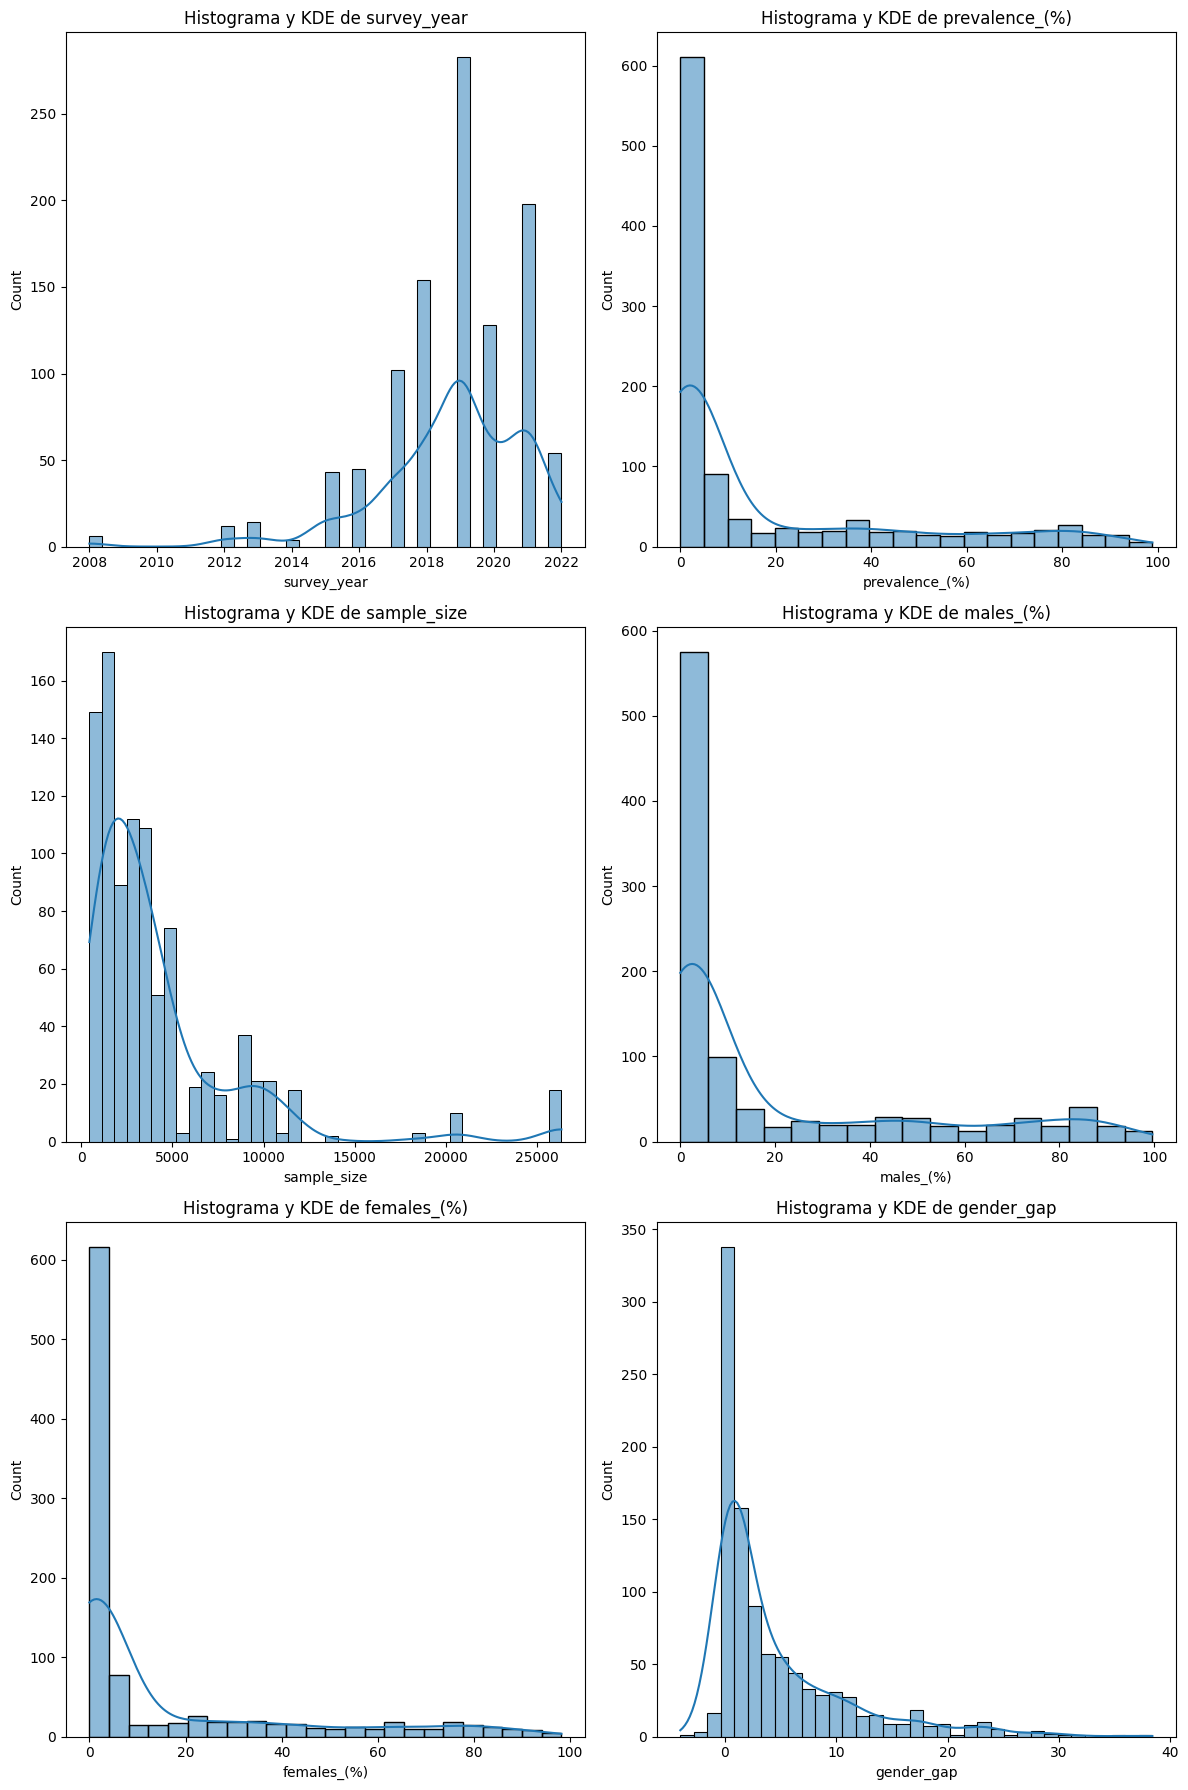

In [51]:
plot_histo_dens(df_drugs, columns=num_cols)

## ANALISIS BIVARIANTE

### **ANÁLISIS BIVARIANTE**

In [73]:
# ===================
# Funciones que voy a usar para análisis bivariante
# las pongo colapsadas para que no ocupen mucho
# ===================

# Función análisis bivariante categóricas
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):

    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(5, 3))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

def grafico_dispersion_con_correlacion(df, columna_x, columna_y, tamano_puntos=50, mostrar_correlacion=False):
    """
    Crea un diagrama de dispersión entre dos columnas y opcionalmente muestra la correlación.

    Args:
    df (pandas.DataFrame): DataFrame que contiene los datos.
    columna_x (str): Nombre de la columna para el eje X.
    columna_y (str): Nombre de la columna para el eje Y.
    tamano_puntos (int, opcional): Tamaño de los puntos en el gráfico. Por defecto es 50.
    mostrar_correlacion (bool, opcional): Si es True, muestra la correlación en el gráfico. Por defecto es False.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x=columna_x, y=columna_y, s=tamano_puntos)

    if mostrar_correlacion:
        correlacion = df[[columna_x, columna_y]].corr().iloc[0, 1]
        plt.title(f'Diagrama de Dispersión con Correlación: {correlacion:.2f}')
    else:
        plt.title('Diagrama de Dispersión')

    plt.xlabel(columna_x)
    plt.ylabel(columna_y)
    plt.grid(True)
    plt.show()

## **CATEGORICAS**

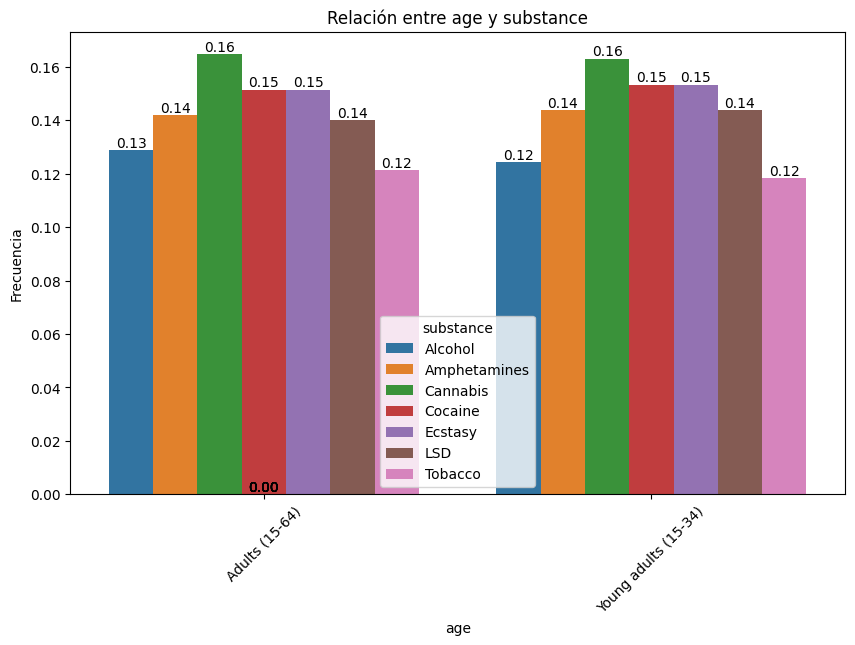

In [81]:
plot_categorical_relationship_fin(df_drugs, "age", "substance", relative_freq=True, show_values=True)

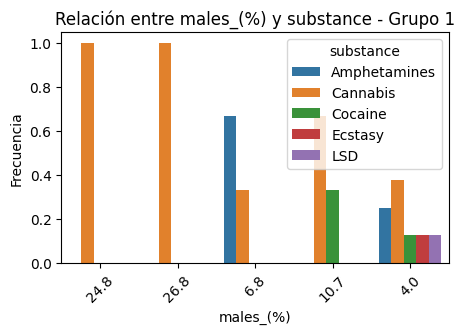

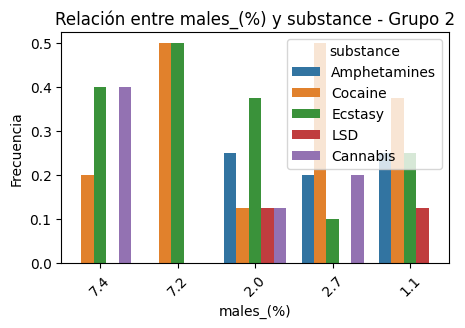

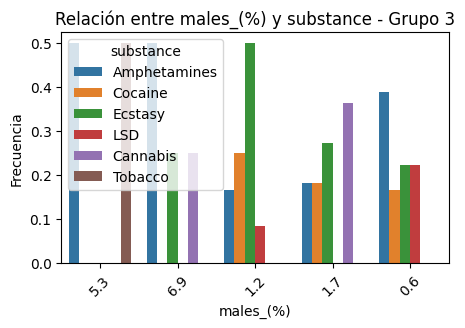

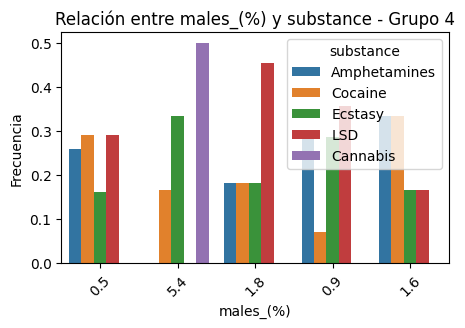

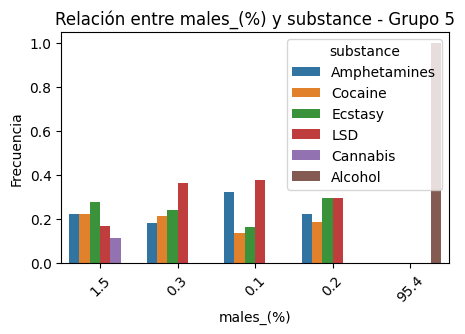

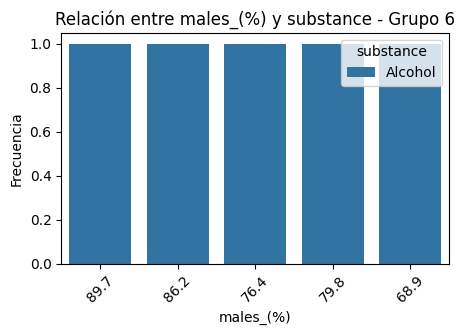

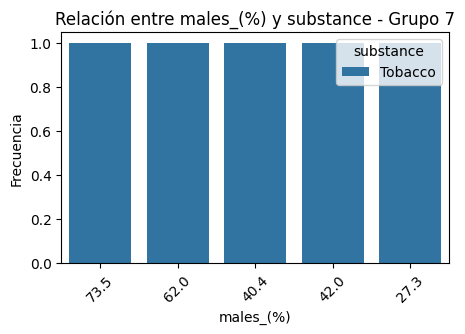

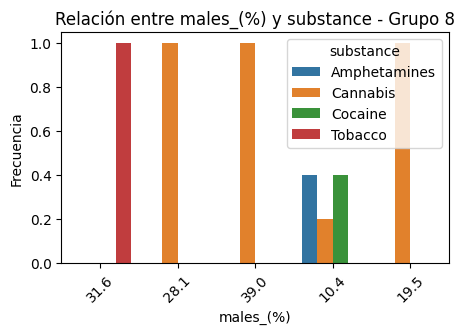

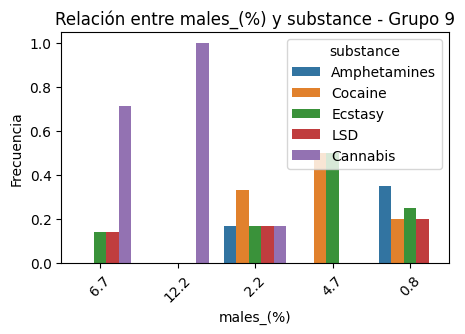

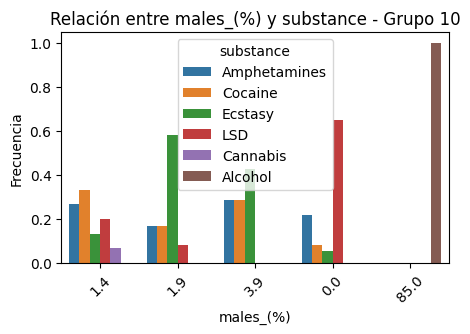

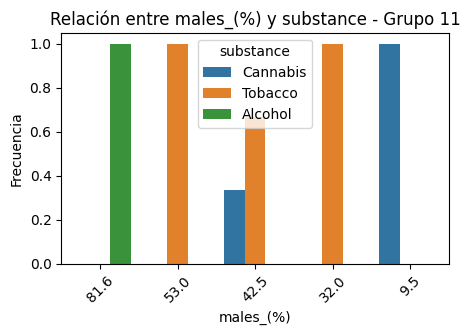

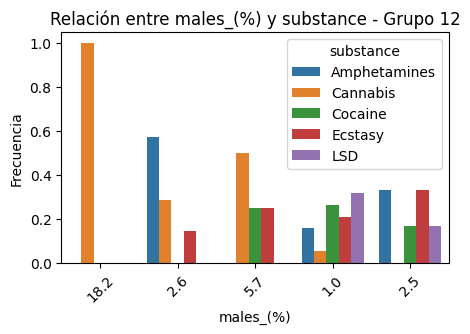

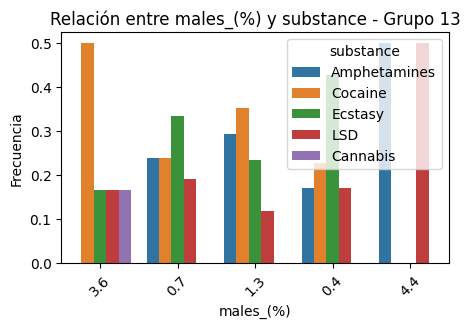

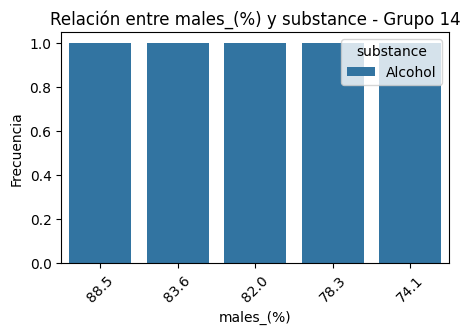

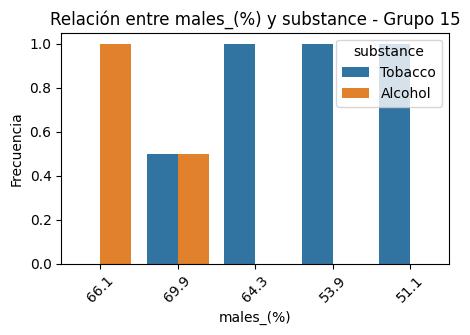

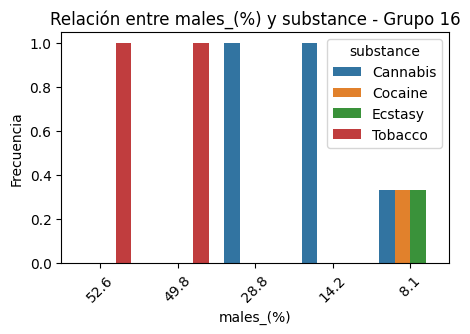

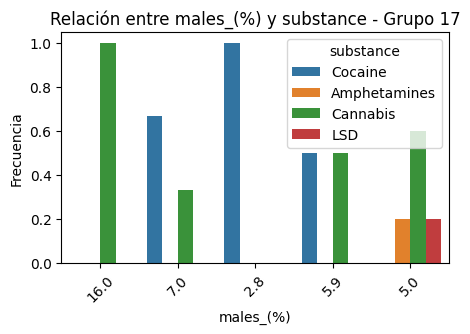

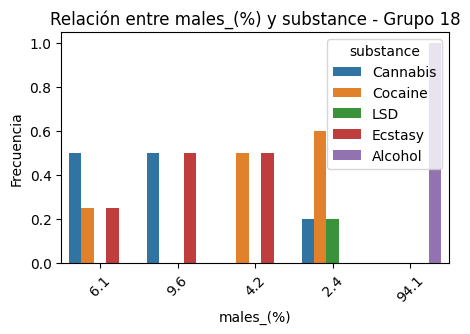

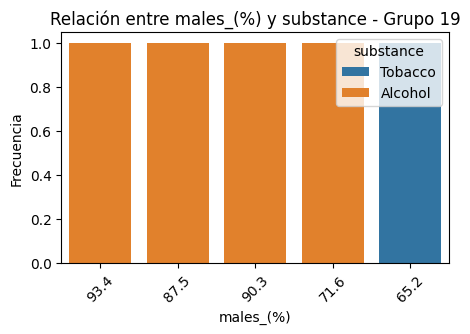

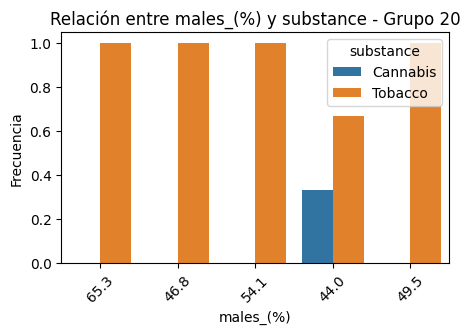

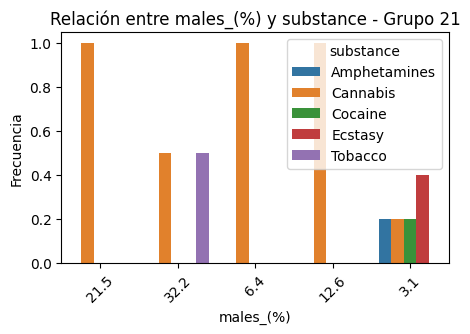

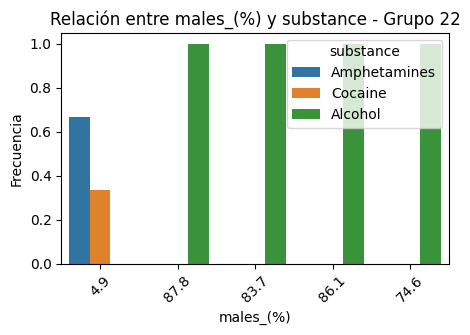

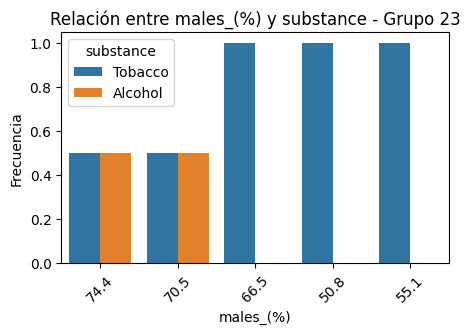

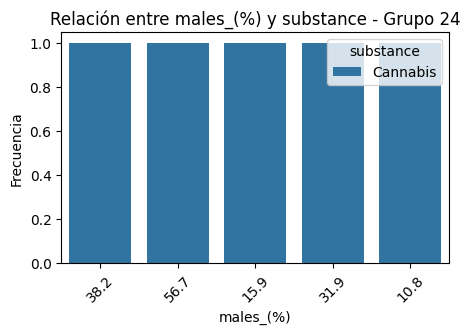

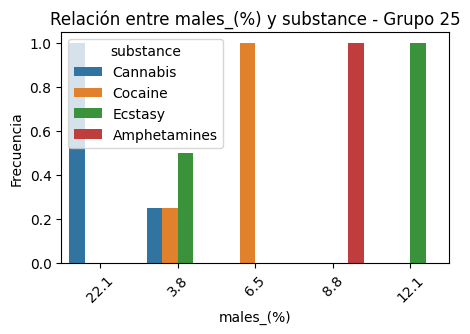

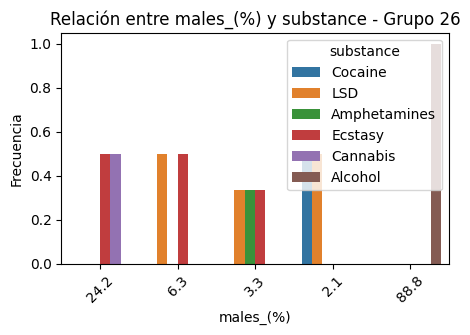

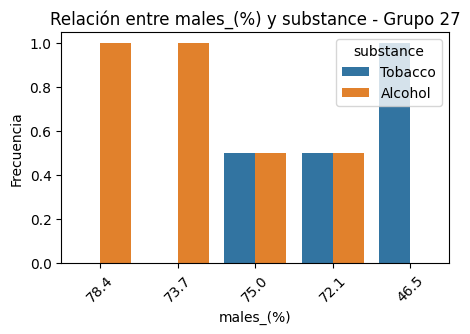

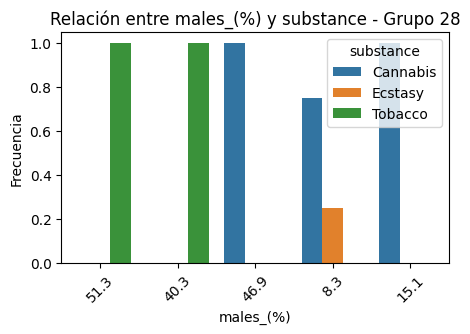

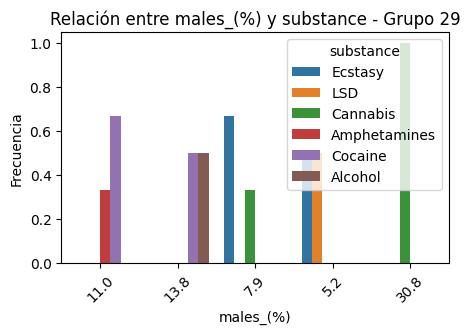

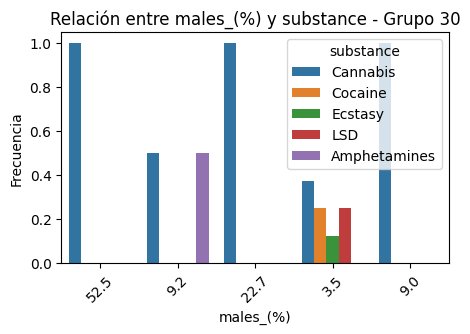

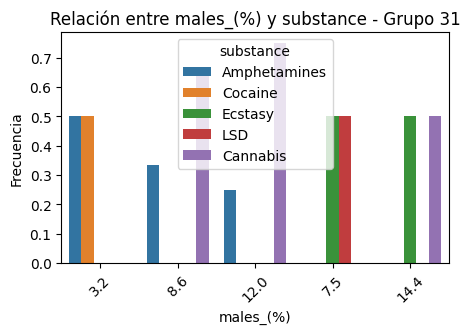

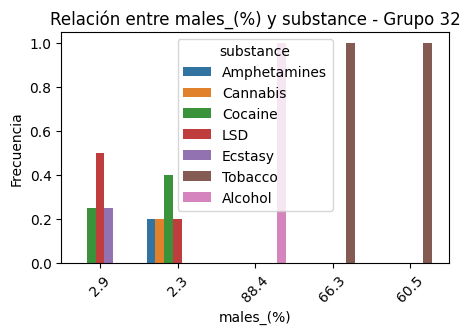

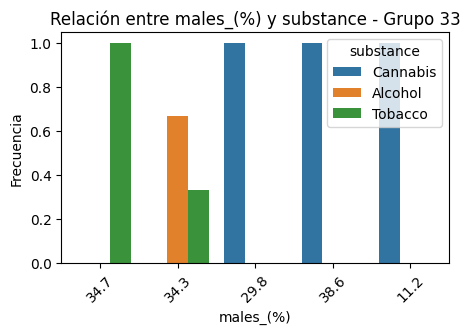

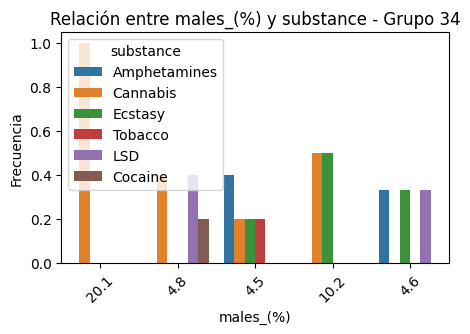

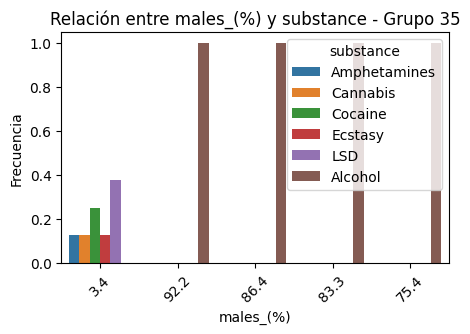

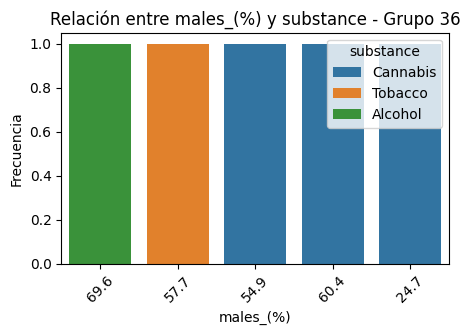

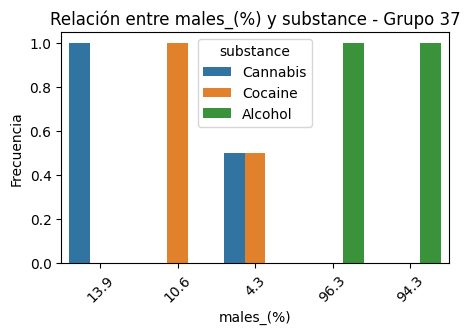

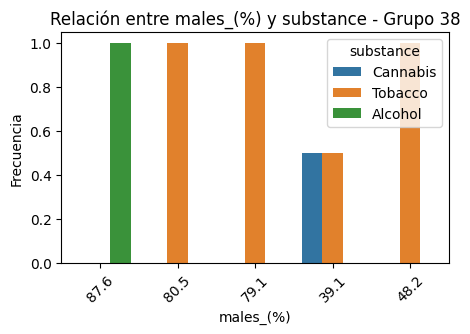

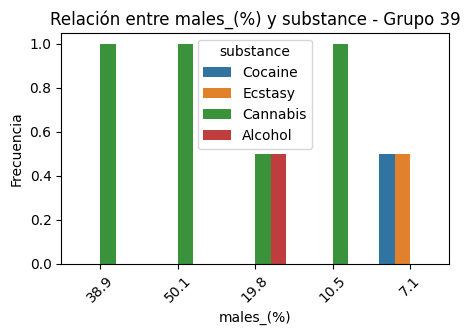

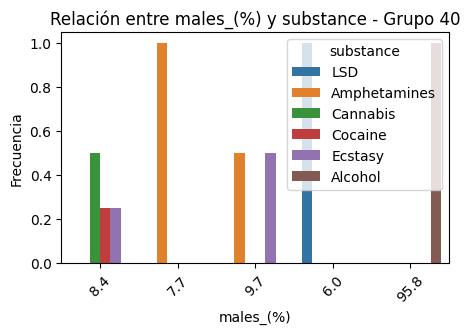

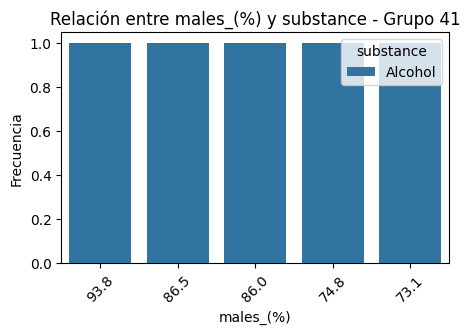

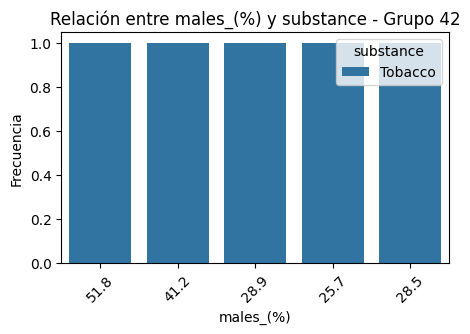

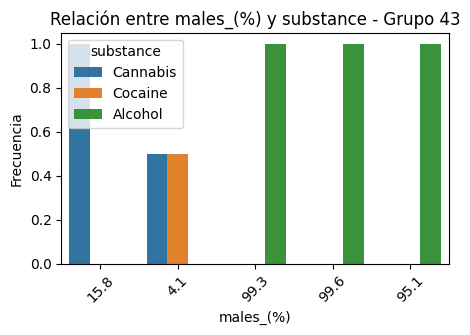

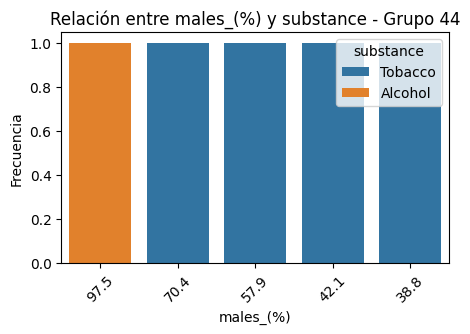

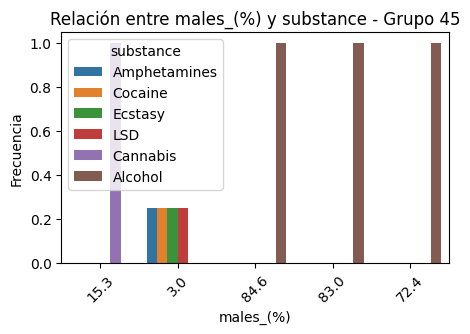

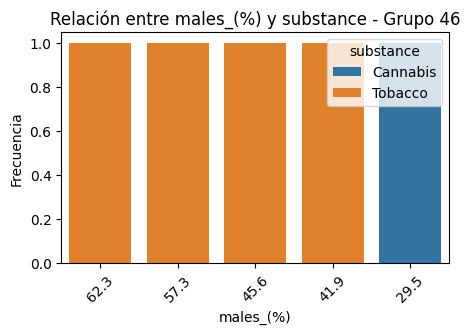

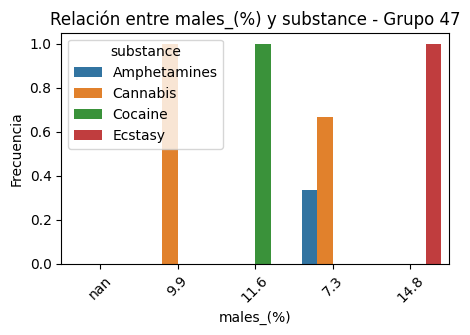

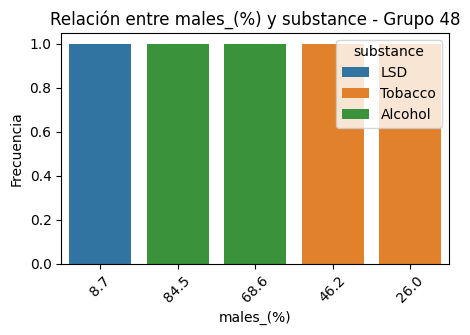

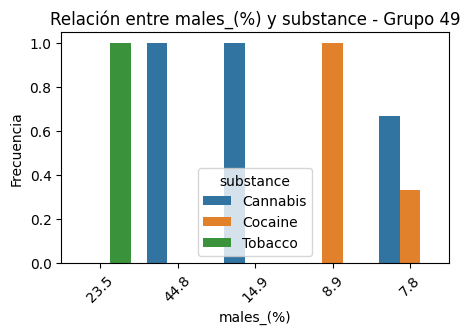

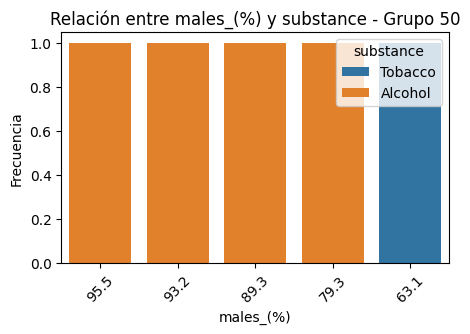

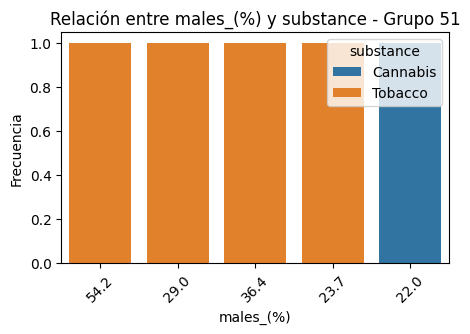

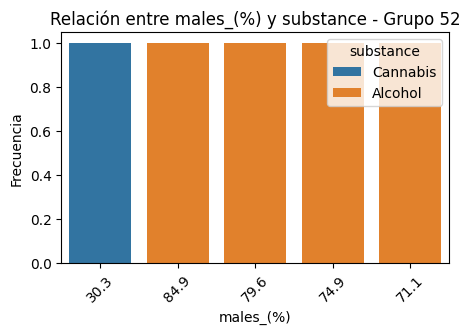

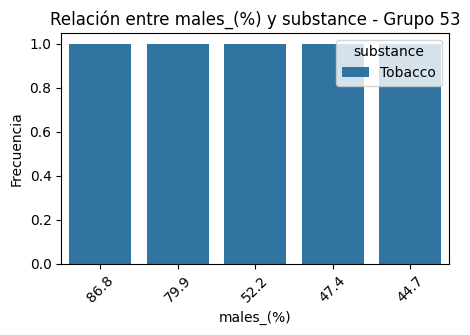

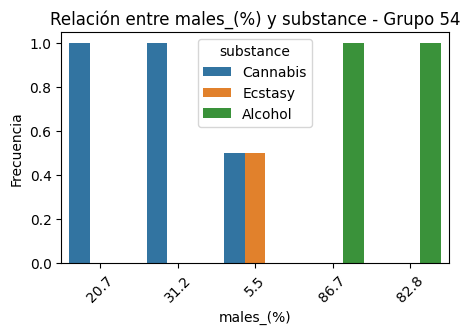

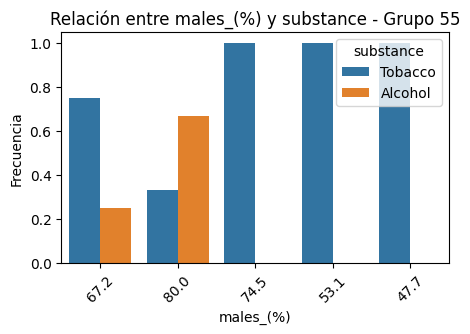

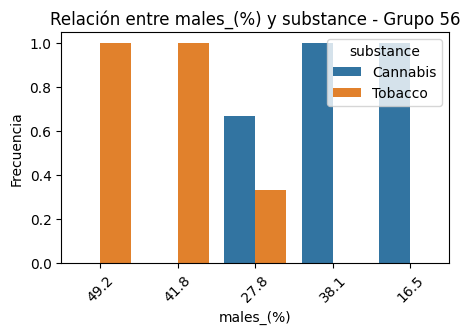

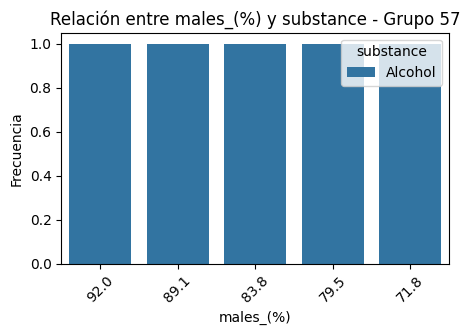

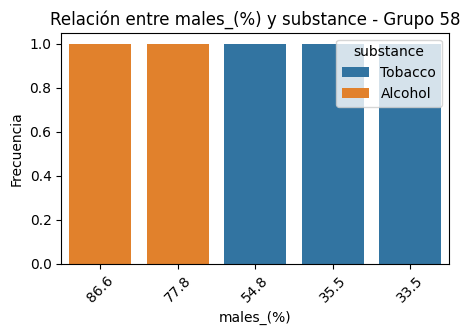

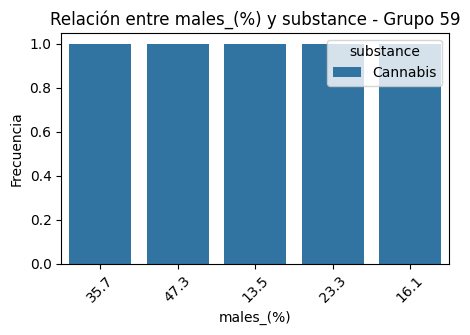

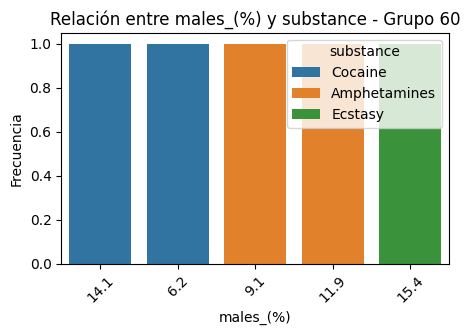

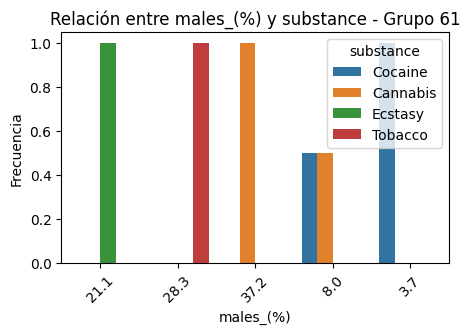

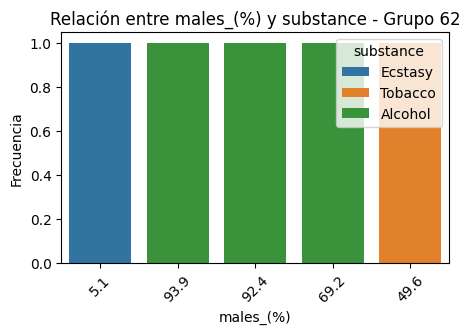

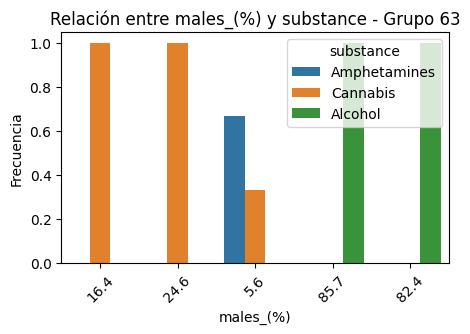

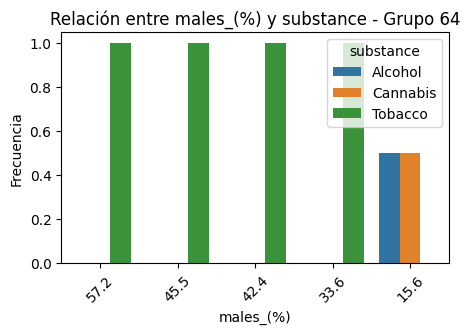

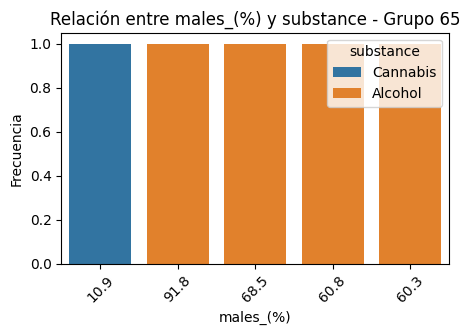

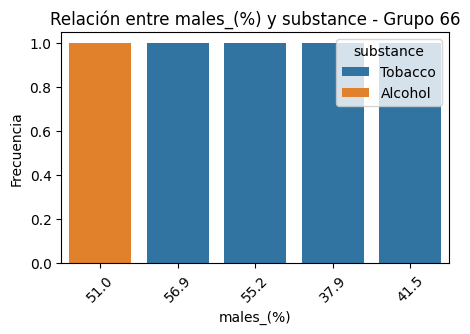

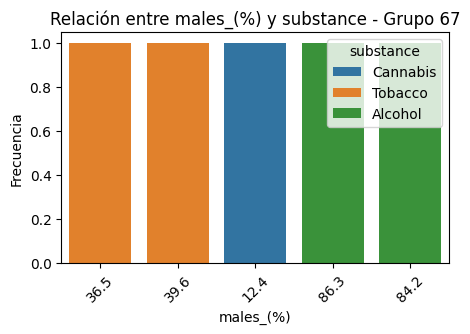

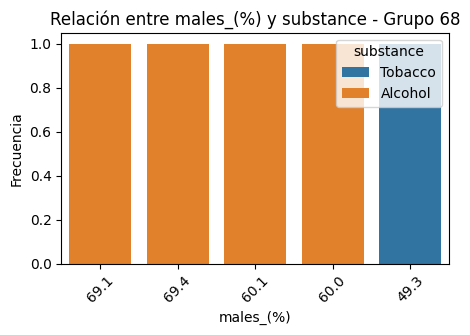

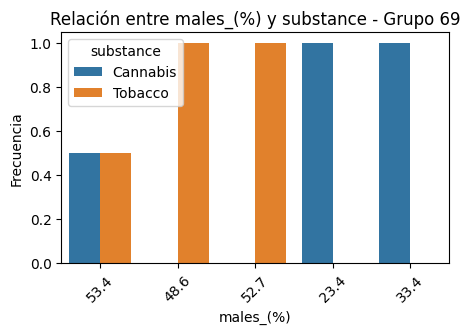

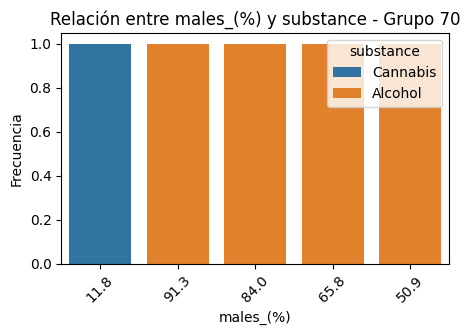

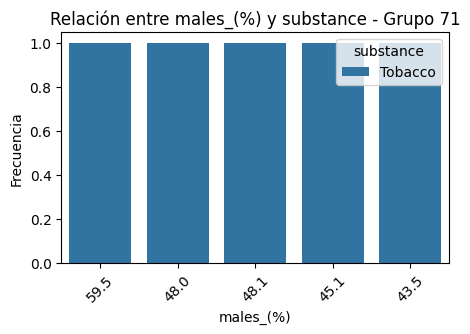

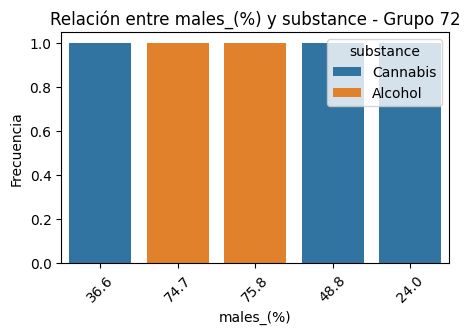

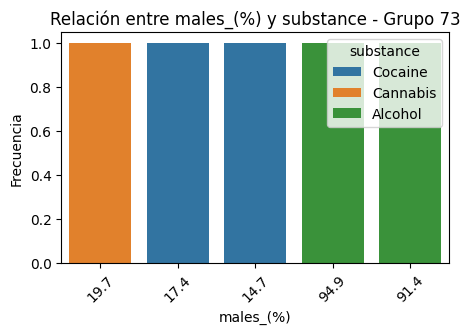

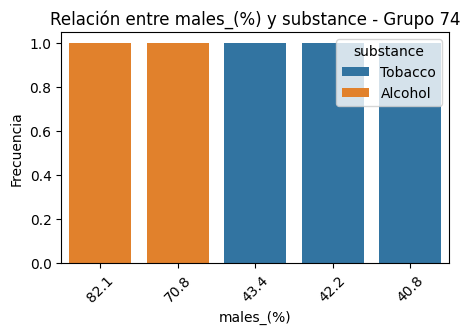

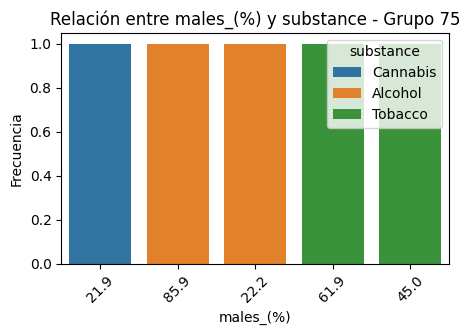

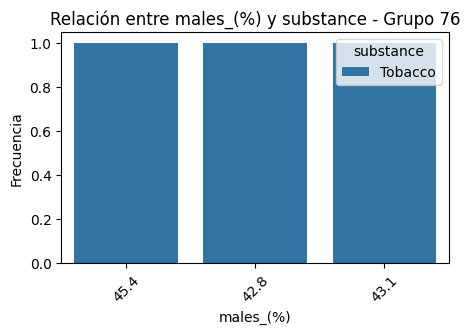

In [80]:
plot_categorical_relationship_fin(df_drugs, "males_(%)", "substance", relative_freq=True)

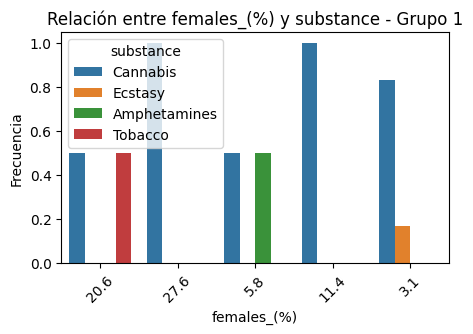

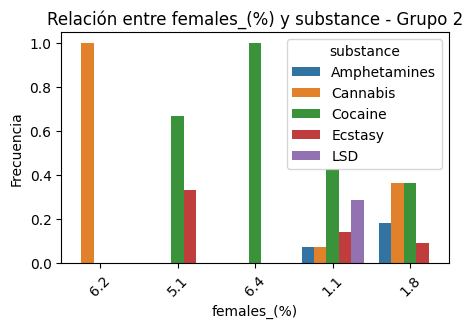

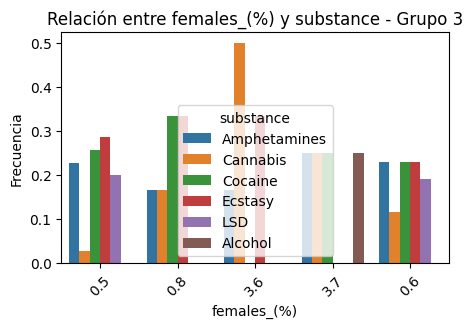

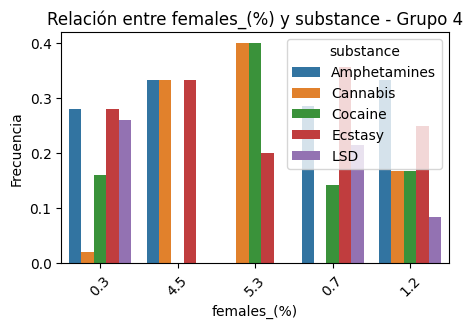

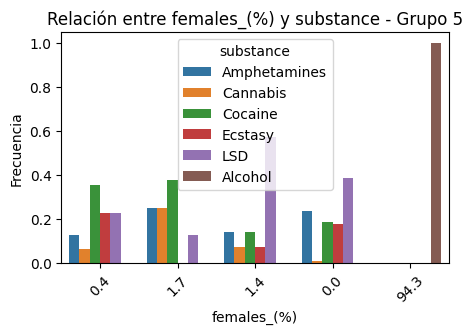

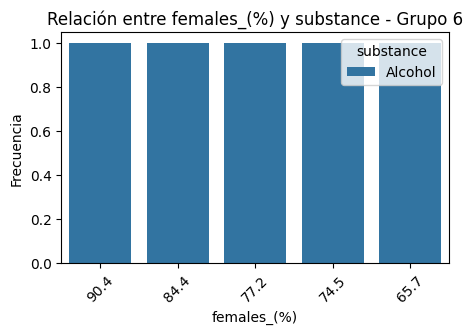

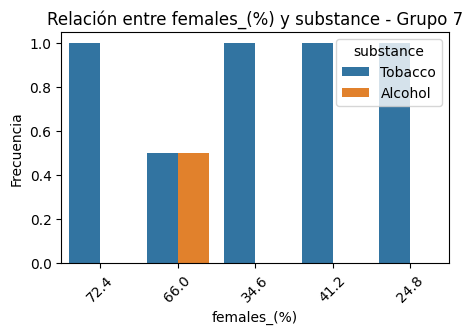

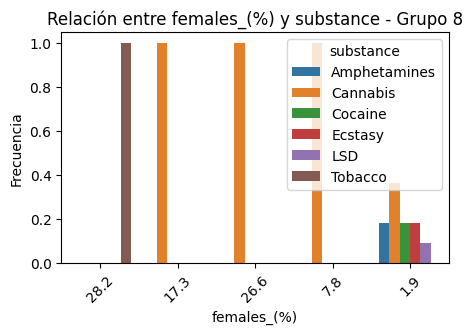

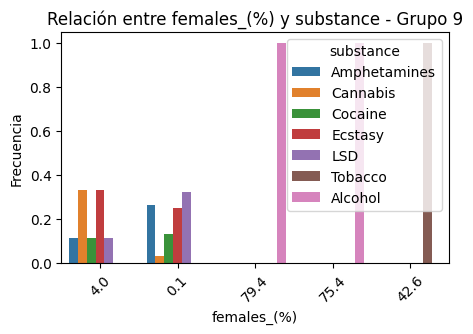

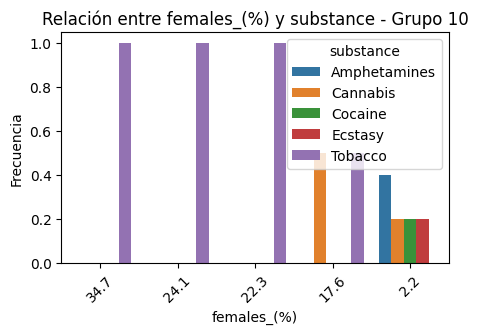

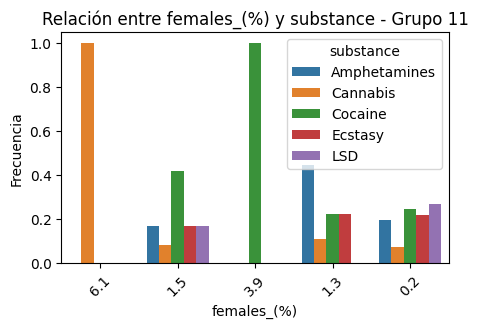

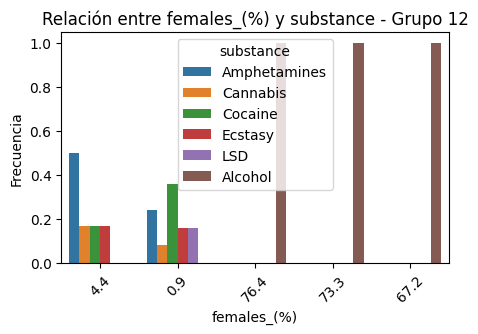

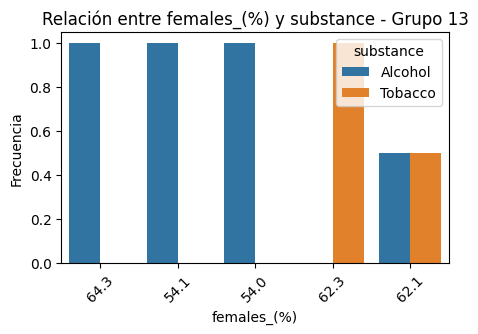

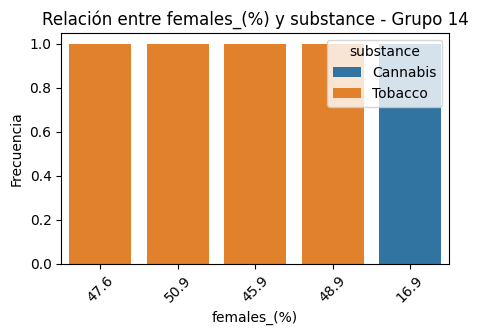

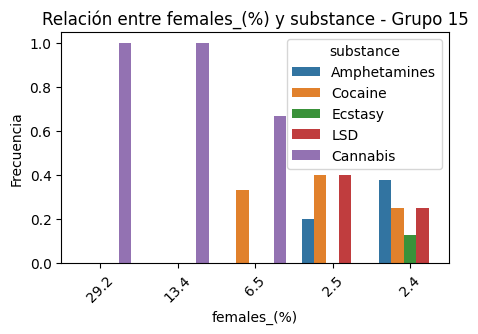

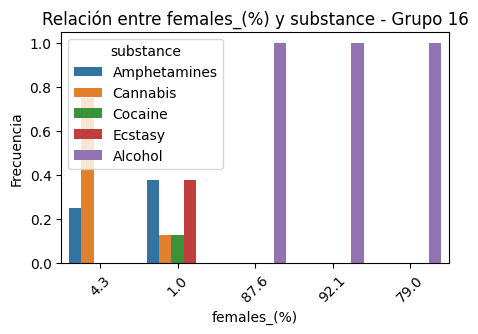

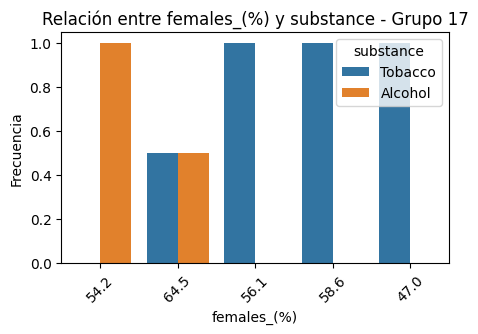

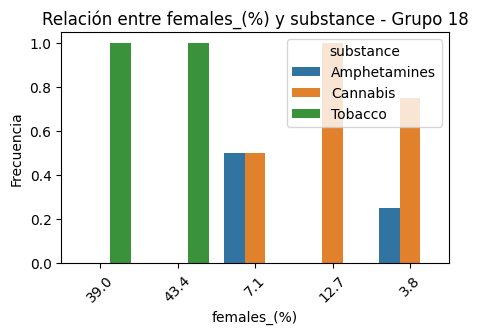

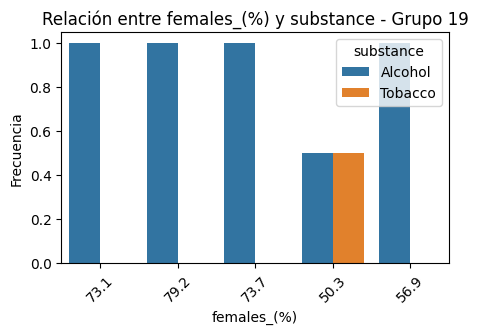

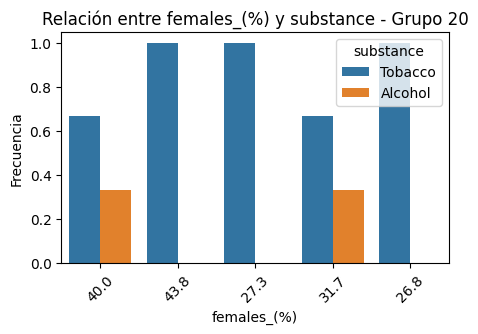

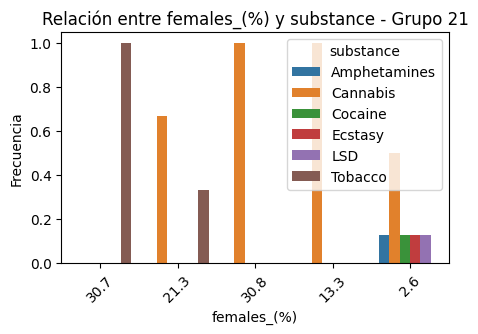

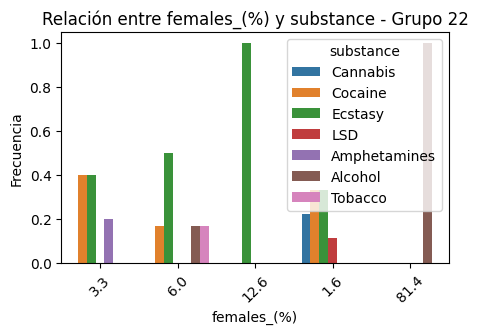

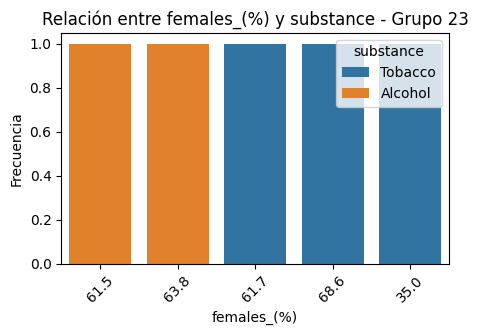

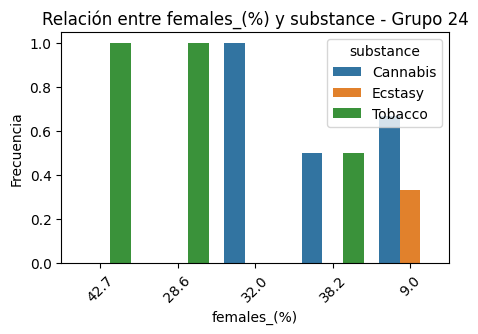

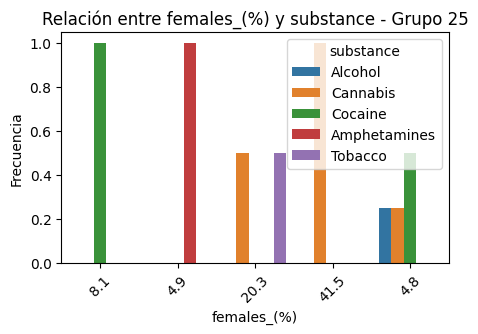

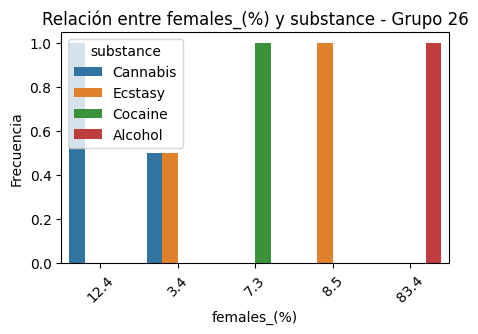

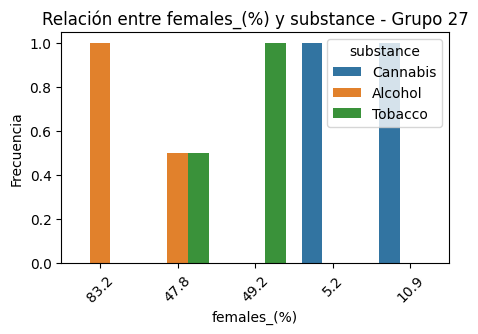

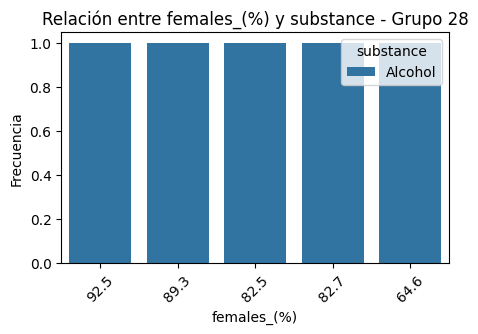

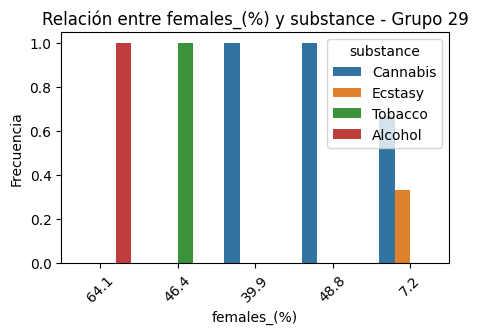

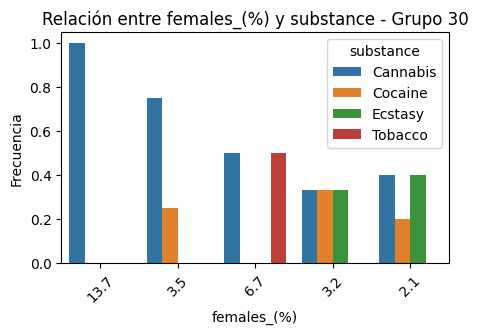

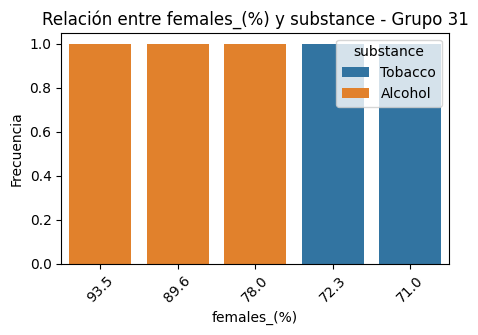

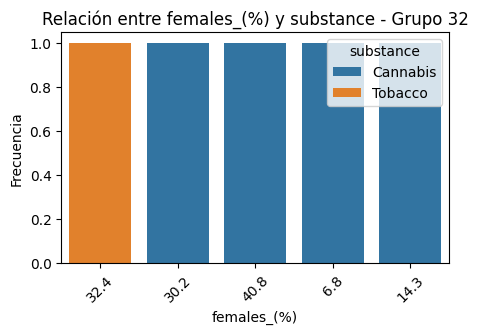

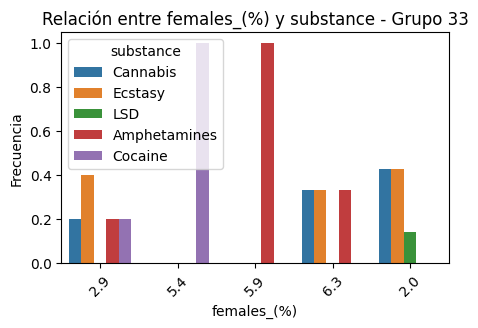

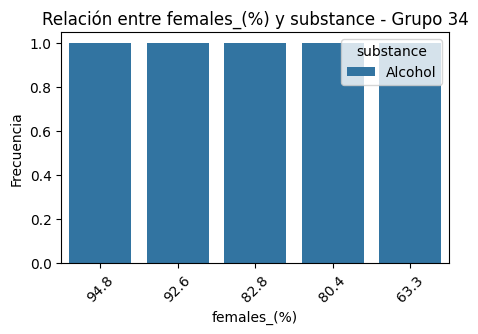

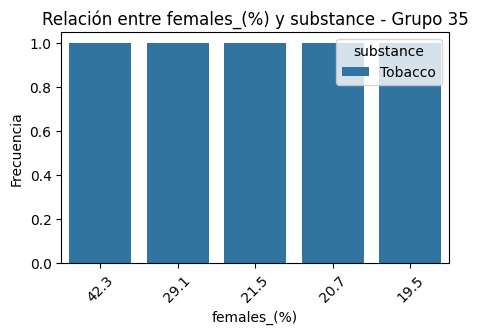

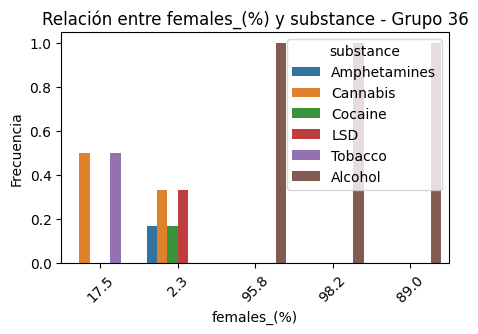

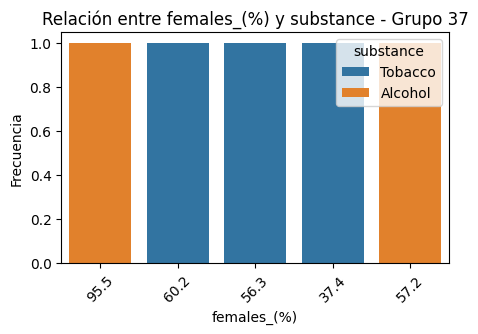

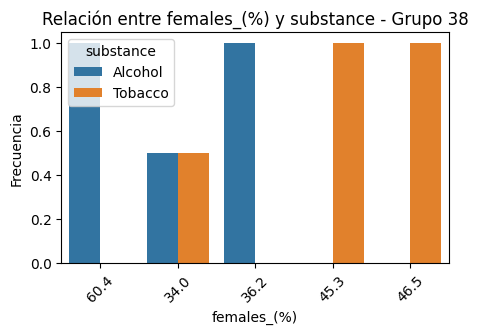

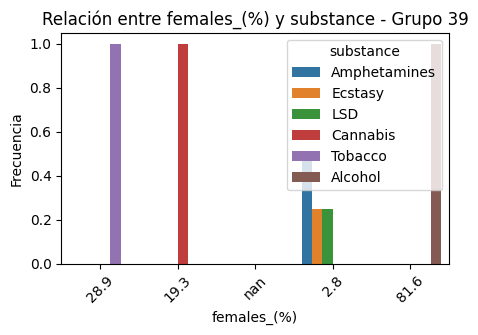

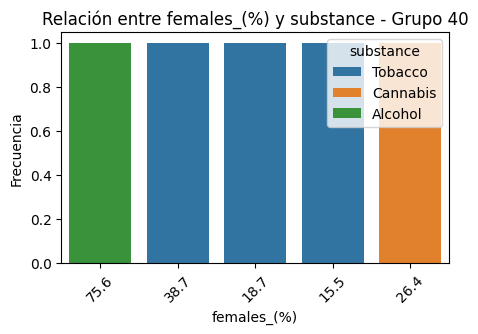

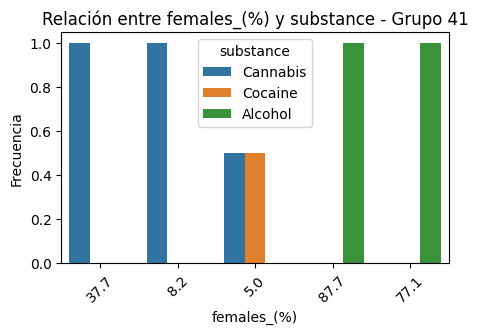

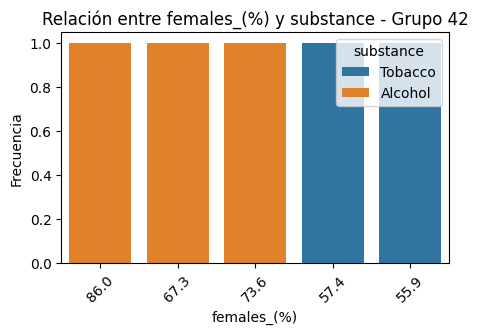

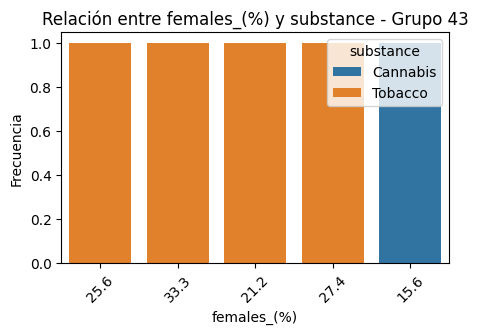

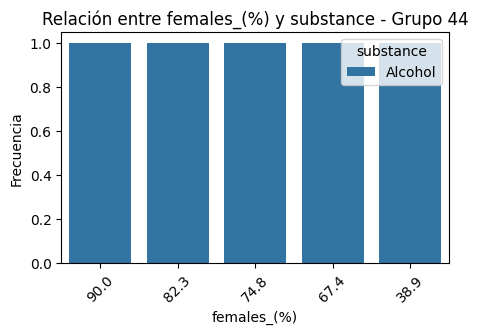

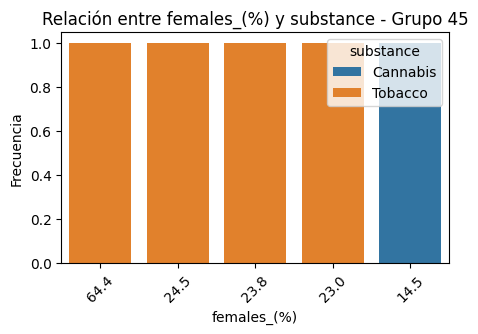

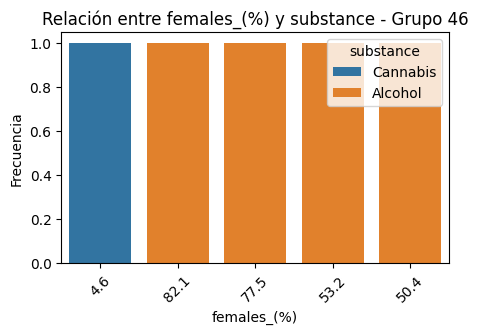

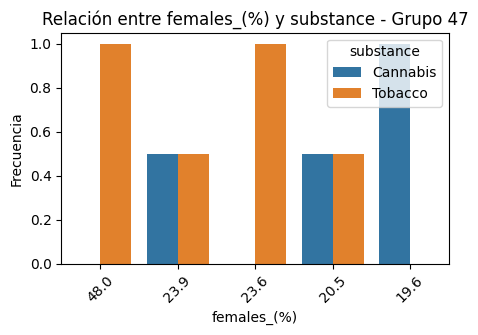

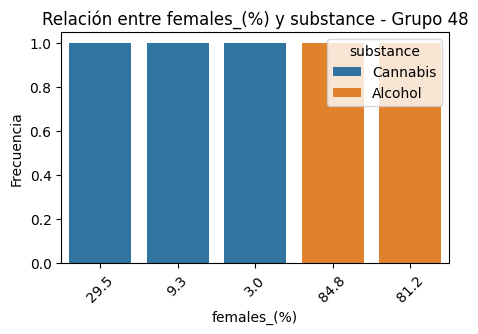

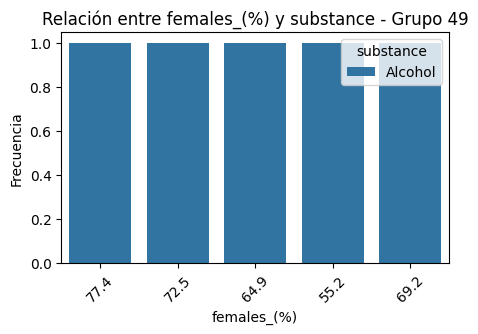

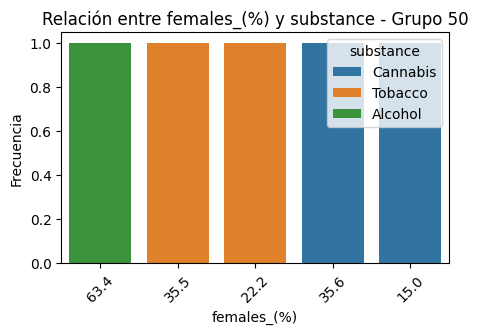

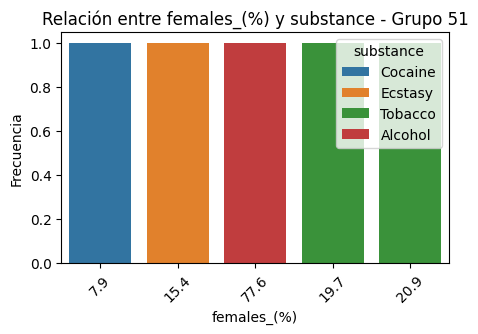

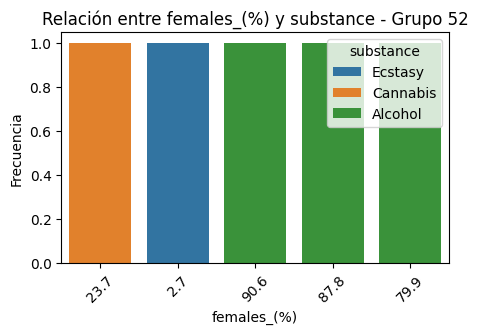

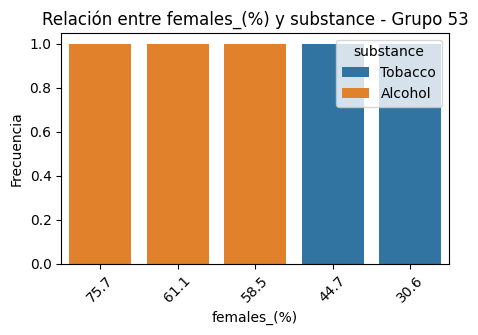

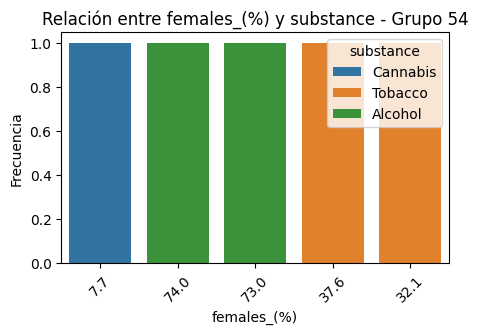

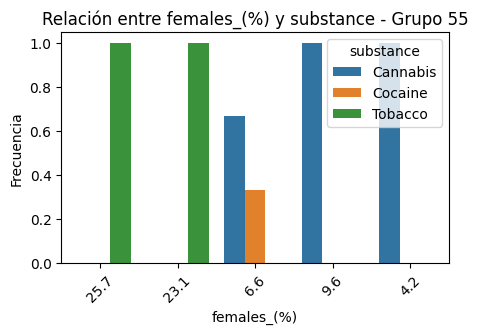

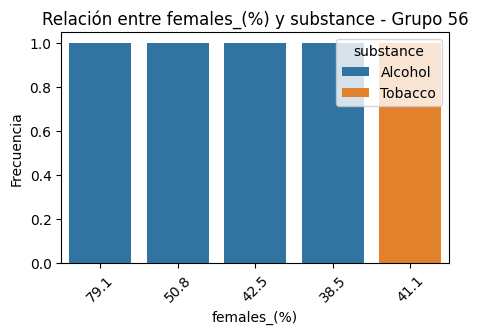

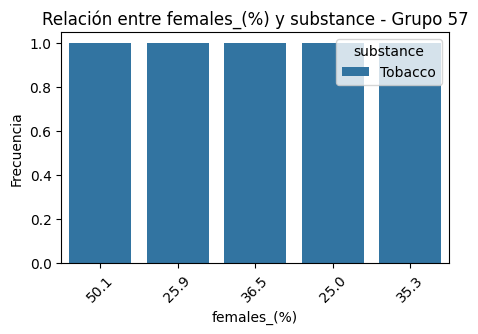

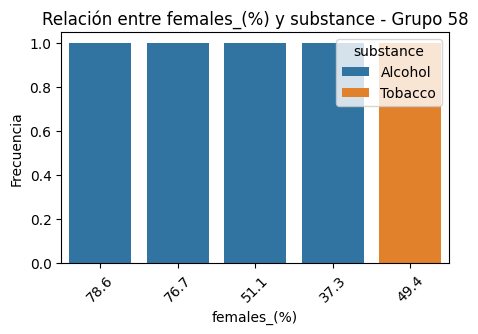

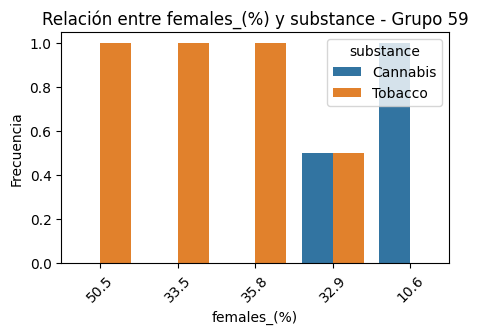

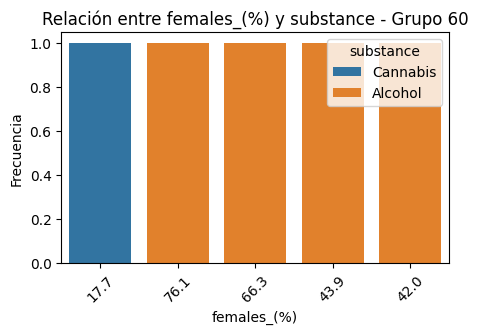

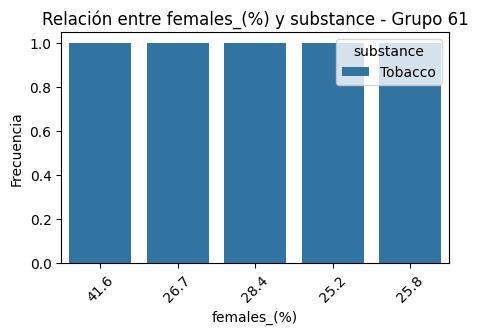

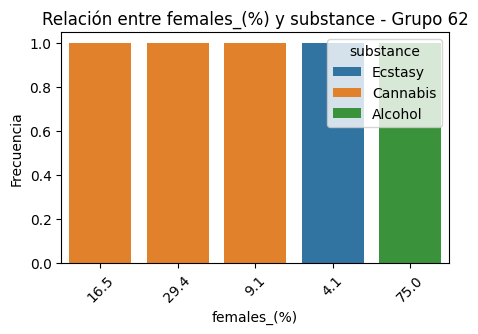

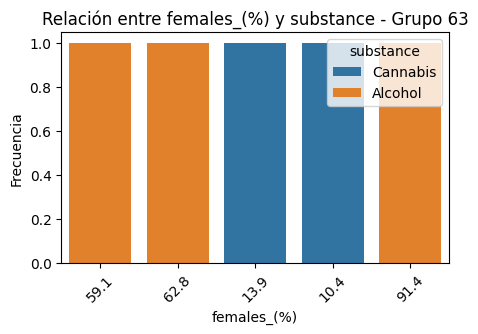

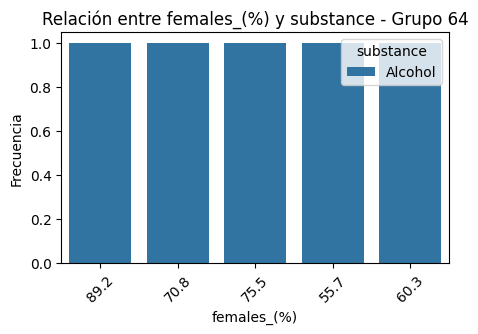

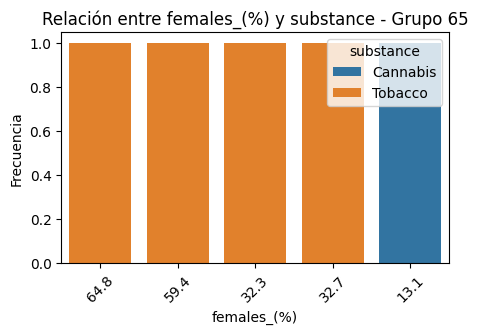

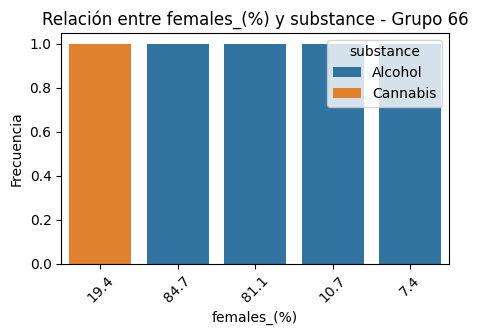

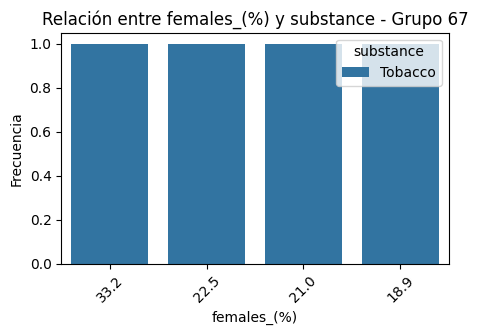

In [79]:
plot_categorical_relationship_fin(df_drugs, "females_(%)", "substance", relative_freq=True)

In [83]:
df_drugs.groupby("age", as_index = False)["substance"].value_counts(normalize = True)

age     substance  proportion
0         Adults (15-64)      Cannabis    0.164773
1         Adults (15-64)       Cocaine    0.151515
2         Adults (15-64)       Ecstasy    0.151515
3         Adults (15-64)  Amphetamines    0.142045
4         Adults (15-64)           LSD    0.140152
5         Adults (15-64)       Alcohol    0.128788
6         Adults (15-64)       Tobacco    0.121212
7   Young adults (15-34)      Cannabis    0.163107
8   Young adults (15-34)       Cocaine    0.153398
9   Young adults (15-34)       Ecstasy    0.153398
10  Young adults (15-34)  Amphetamines    0.143689
11  Young adults (15-34)           LSD    0.143689
12  Young adults (15-34)       Alcohol    0.124272
13  Young adults (15-34)       Tobacco    0.118447

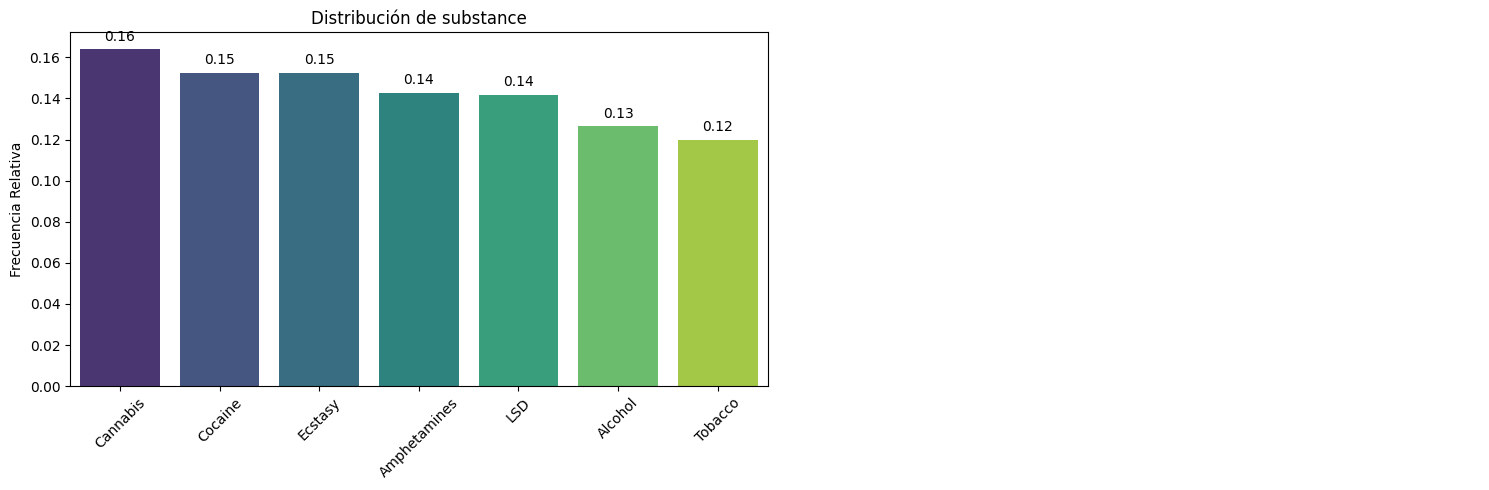

In [86]:
pinta_distribucion_categoricas(df_drugs,["substance"], relativa= True, mostrar_valores= True)

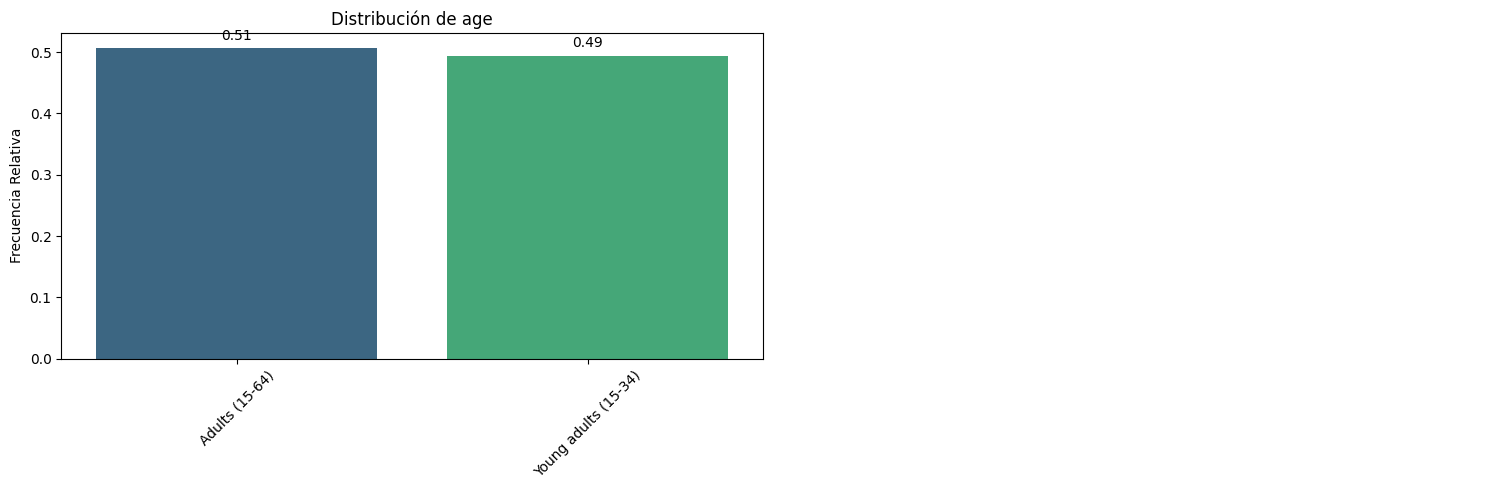

In [89]:
pinta_distribucion_categoricas(df_drugs,["age"], relativa= True, mostrar_valores= True)

In [95]:
df_drugs.groupby("substance")["males_(%)"].describe()

count       mean        std   min    25%    50%    75%   max
substance                                                                 
Alcohol       129.0  78.879845  15.780998  13.8  73.10  83.00  87.80  99.6
Amphetamines  145.0   2.236552   2.797117   0.0   0.40   1.10   2.70  12.0
Cannabis      166.0  16.225904  13.880948   1.0   5.75  11.05  23.85  60.4
Cocaine       155.0   2.928387   3.370301   0.0   0.60   1.60   3.65  17.4
Ecstasy       155.0   2.794839   3.828427   0.0   0.45   1.30   3.70  24.2
LSD           145.0   1.250345   1.665213   0.0   0.10   0.50   1.80   8.7
Tobacco       122.0  49.027049  15.038969   4.5  40.90  48.15  57.60  86.8

In [96]:
df_drugs.groupby("substance")["females_(%)"].describe()

count       mean        std  min     25%    50%     75%   max
substance                                                                  
Alcohol       129.0  68.759690  20.472777  3.7  60.300  74.80  82.500  98.2
Amphetamines  143.0   1.090909   1.469066  0.0   0.100   0.50   1.350   7.1
Cannabis      166.0   9.627108  10.679300  0.0   2.125   5.25  13.375  48.8
Cocaine       151.0   1.435099   1.806477  0.0   0.250   0.80   1.750   8.1
Ecstasy       151.0   1.468874   2.288353  0.0   0.200   0.60   1.850  15.4
LSD           139.0   0.533094   0.744194  0.0   0.000   0.20   0.650   4.0
Tobacco       122.0  36.686066  14.695681  6.0  24.850  34.30  46.275  72.4

In [97]:
df_drugs.groupby("substance")["age"].describe()

count unique             top freq
substance                                     
Alcohol        132      2  Adults (15-64)   68
Amphetamines   149      2  Adults (15-64)   75
Cannabis       171      2  Adults (15-64)   87
Cocaine        159      2  Adults (15-64)   80
Ecstasy        159      2  Adults (15-64)   80
LSD            148      2  Adults (15-64)   74
Tobacco        125      2  Adults (15-64)   64

In [99]:
df_drugs.groupby("substance")["prevalence_(%)"].describe()

count       mean        std  min     25%   50%   75%   max
substance                                                               
Alcohol       132.0  73.750758  17.686176  8.6  65.825  78.4  84.4  98.9
Amphetamines  149.0   1.663758   2.091366  0.0   0.300   0.7   2.2   9.1
Cannabis      171.0  12.817544  12.108385  0.4   3.950   8.2  19.1  54.5
Cocaine       159.0   2.214465   2.617585  0.0   0.400   1.3   2.8  12.0
Ecstasy       159.0   2.201258   3.130839  0.0   0.400   0.9   2.7  18.6
LSD           148.0   0.925676   1.252922  0.0   0.100   0.4   1.3   6.6
Tobacco       125.0  42.397600  14.321698  5.3  33.400  39.0  51.0  76.3

In [102]:
df_drugs.groupby("age")["prevalence_(%)"].describe()

count       mean        std  min  25%  50%     75%   max
age                                                                           
Adults (15-64)        528.0  17.150568  27.181936  0.0  0.5  2.2  24.675  97.6
Young adults (15-34)  515.0  17.976893  26.338707  0.0  0.8  3.5  27.300  98.9

In [103]:
df_drugs.groupby("males_(%)")["prevalence_(%)"].describe()

count       mean       std   min   25%   50%    75%   max
males_(%)                                                           
0.0         37.0   0.018919  0.051843   0.0   0.0   0.0   0.00   0.2
0.1         37.0   0.078378  0.041734   0.0   0.1   0.1   0.10   0.1
0.2         27.0   0.137037  0.056488   0.1   0.1   0.1   0.20   0.3
0.3         33.0   0.209091  0.076500   0.1   0.2   0.2   0.30   0.4
0.4         35.0   0.291429  0.112122   0.2   0.2   0.3   0.35   0.7
...          ...        ...       ...   ...   ...   ...    ...   ...
95.8         1.0  95.300000       NaN  95.3  95.3  95.3  95.30  95.3
96.3         1.0  94.900000       NaN  94.9  94.9  94.9  94.90  94.9
97.5         1.0  96.600000       NaN  96.6  96.6  96.6  96.60  96.6
99.3         1.0  97.600000       NaN  97.6  97.6  97.6  97.60  97.6
99.6         1.0  98.900000       NaN  98.9  98.9  98.9  98.90  98.9

[377 rows x 8 columns]

In [104]:
df_drugs.groupby("prevalence_(%)")["males_(%)"].describe()

count       mean       std   min     25%    50%     75%   max
prevalence_(%)                                                               
0.0              40.0   0.020000  0.040510   0.0   0.000   0.00   0.000   0.1
0.1              57.0   0.150877  0.078200   0.0   0.100   0.10   0.200   0.3
0.2              45.0   0.313333  0.105744   0.0   0.300   0.30   0.400   0.5
0.3              34.0   0.423529  0.101679   0.2   0.325   0.40   0.500   0.6
0.4              40.0   0.612500  0.182837   0.3   0.500   0.60   0.725   1.0
...               ...        ...       ...   ...     ...    ...     ...   ...
94.9              2.0  95.850000  0.636396  95.4  95.625  95.85  96.075  96.3
95.3              1.0  95.800000       NaN  95.8  95.800  95.80  95.800  95.8
96.6              1.0  97.500000       NaN  97.5  97.500  97.50  97.500  97.5
97.6              1.0  99.300000       NaN  99.3  99.300  99.30  99.300  99.3
98.9              1.0  99.600000       NaN  99.6  99.600  99.60  99.600  99.6

[358 rows x 8 columns]

(6, 2)


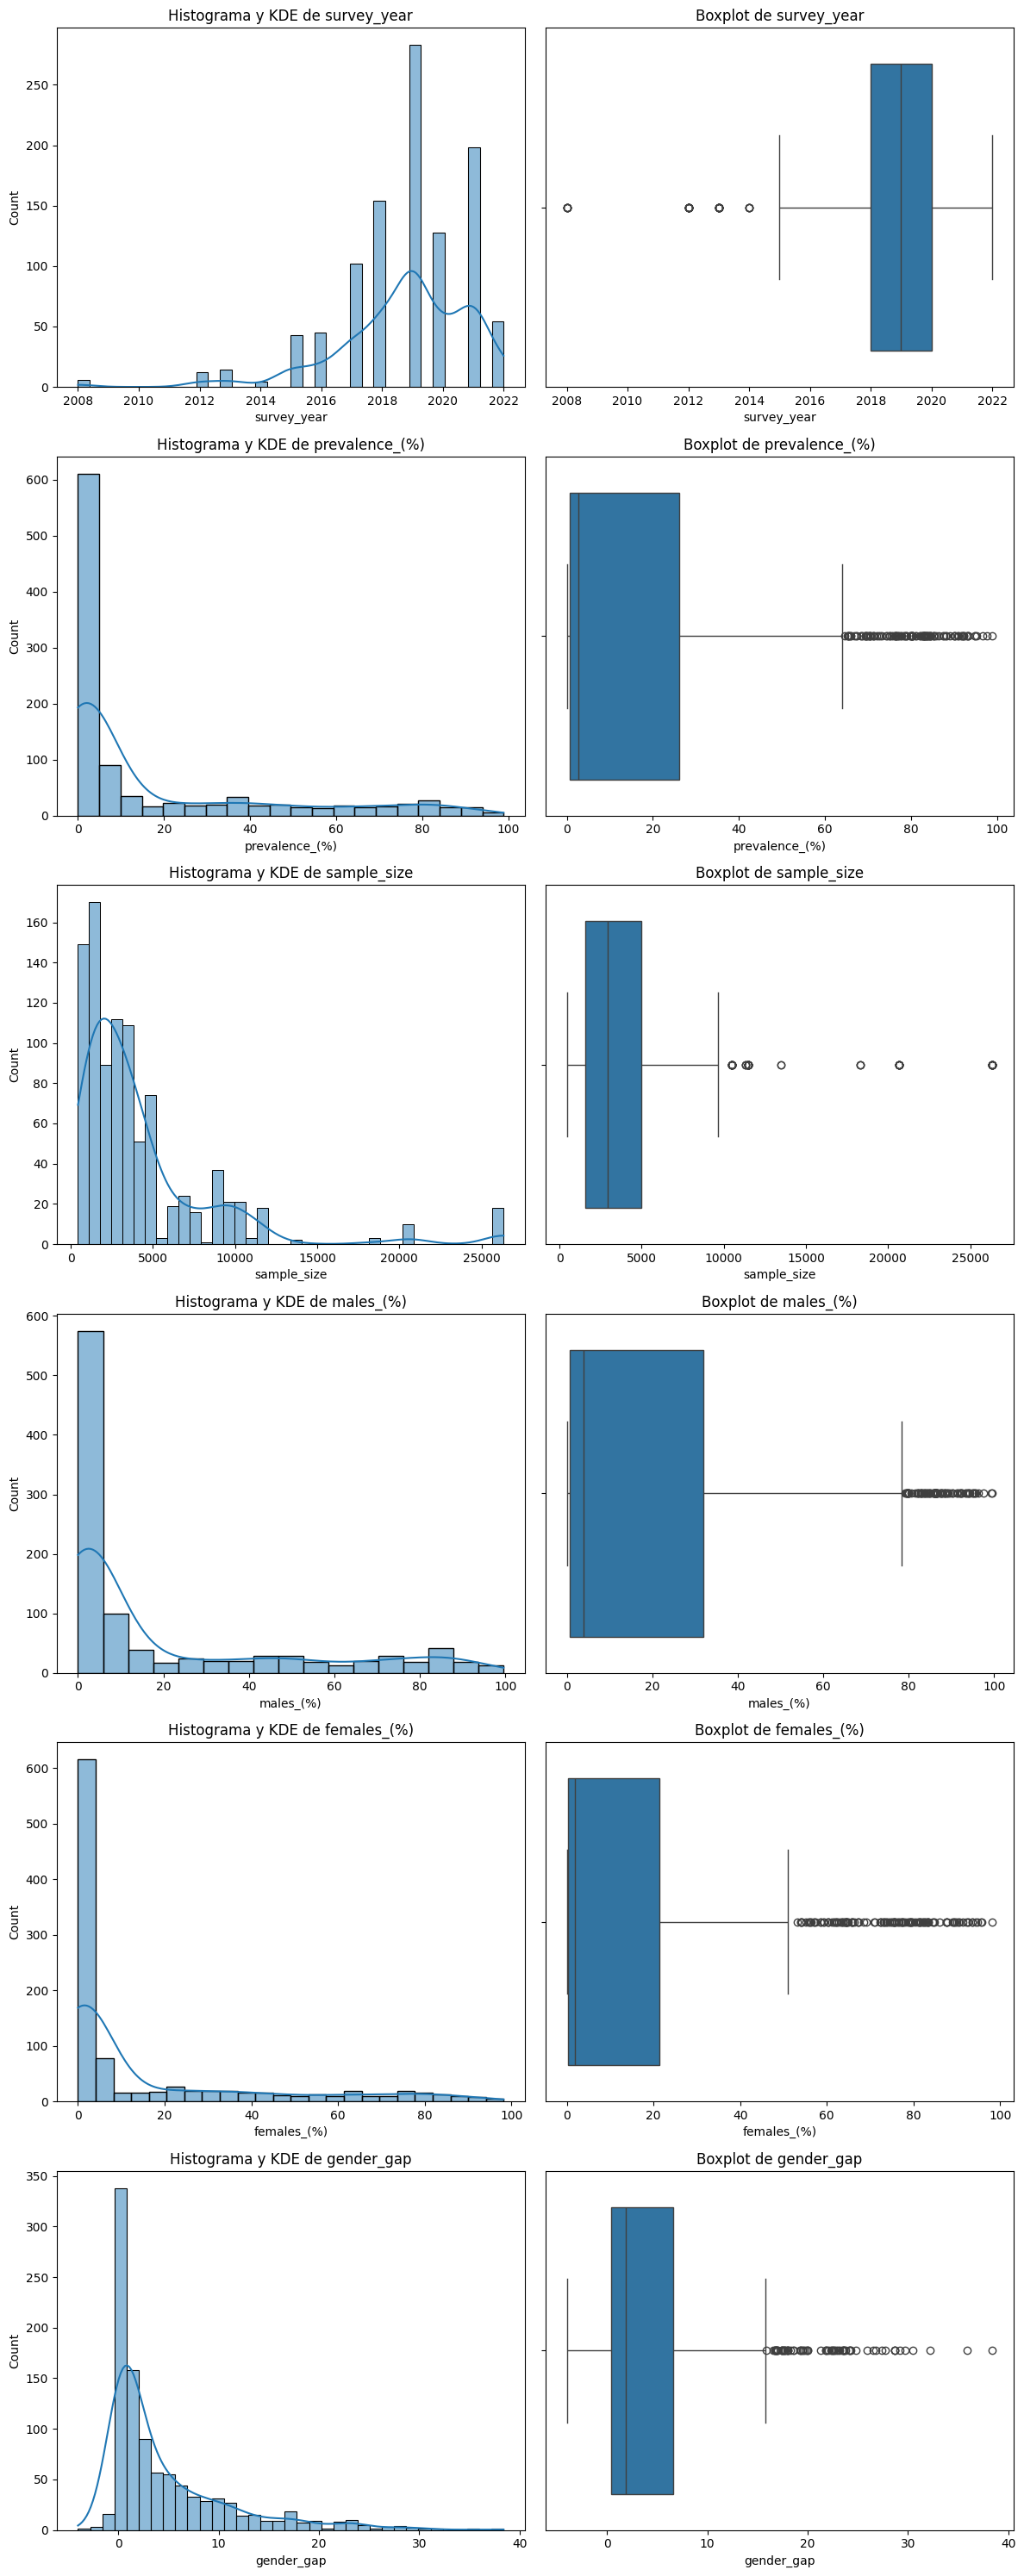

In [105]:
plot_combined_graphs(df_drugs, columns=num_cols)

(2,)


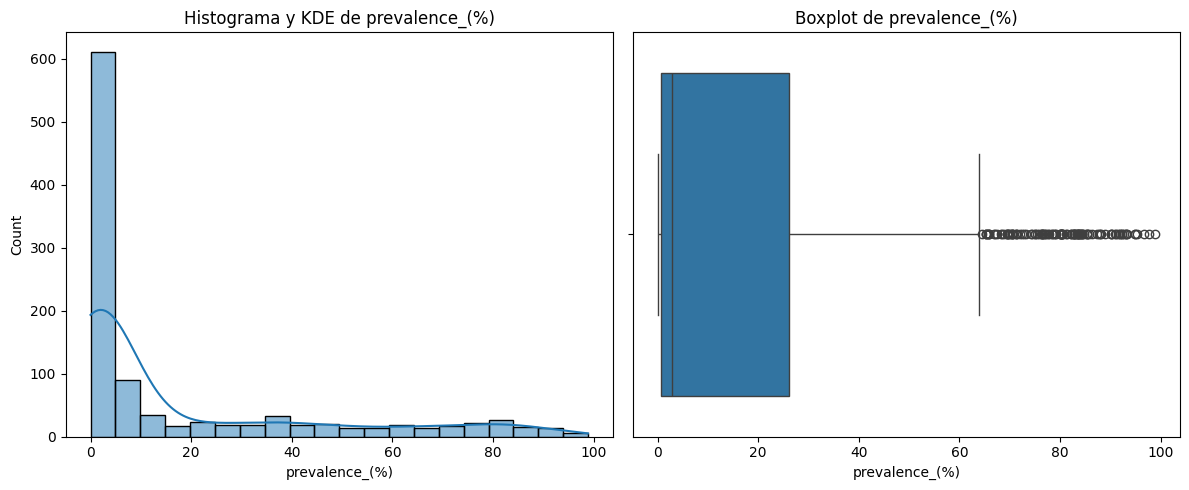

In [107]:
plot_combined_graphs(df_drugs,["prevalence_(%)"])

**NUMERICAS**

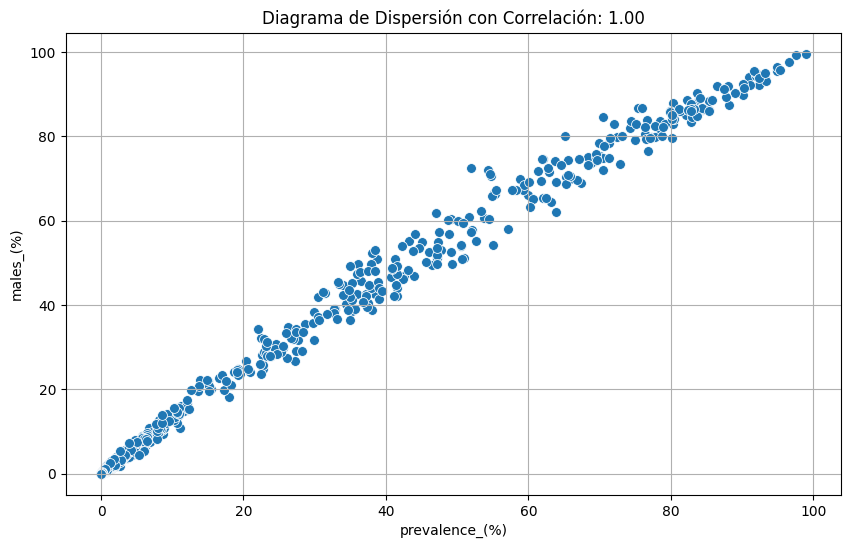

In [112]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "males_(%)", mostrar_correlacion=True)

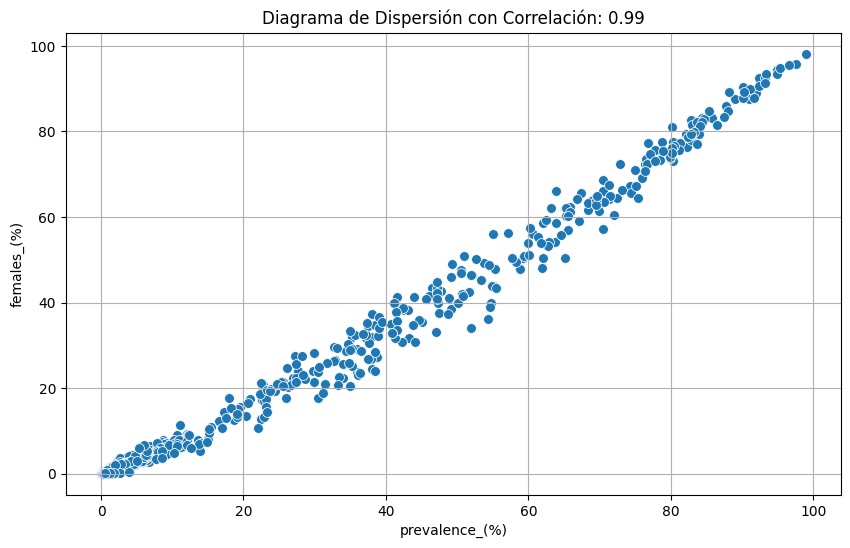

In [113]:
grafico_dispersion_con_correlacion(df_drugs, "prevalence_(%)", "females_(%)", mostrar_correlacion=True)

In [115]:
df_drugs[["prevalence_(%)","females_(%)"]].corr()

prevalence_(%)  females_(%)
prevalence_(%)        1.000000     0.994642
females_(%)           0.994642     1.000000

In [116]:
df_drugs[["prevalence_(%)","males_(%)"]].corr()

prevalence_(%)  males_(%)
prevalence_(%)        1.000000   0.995688
males_(%)             0.995688   1.000000

**P VALOR ::: CATEGORICA - CATEGORICA**



**sustancia - year**


chi-cuadrado

In [122]:
tabla_contingencia = pd.crosstab(df_drugs['substance'], df_drugs['age'])
tabla_contingencia

age           Adults (15-64)  Young adults (15-34)
substance                                         
Alcohol                   68                    64
Amphetamines              75                    74
Cannabis                  87                    84
Cocaine                   80                    79
Ecstasy                   80                    79
LSD                       74                    74
Tobacco                   64                    61

In [123]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(tabla_contingencia)


print("Valor Chi-Cuadrado:", chi2)
print("P-Value:", p)
print("Grados de Libertad:", dof)
print("Tabla de Frecuencias Esperadas:\n", expected)


Valor Chi-Cuadrado: 0.10311714713419907
P-Value: 0.9999780224419544
Grados de Libertad: 6
Tabla de Frecuencias Esperadas:
 [[66.82262704 65.17737296]
 [75.42857143 73.57142857]
 [86.56567593 84.43432407]
 [80.49089166 78.50910834]
 [80.49089166 78.50910834]
 [74.92233941 73.07766059]
 [63.27900288 61.72099712]]


**P VALOR ::: CATEGORICA - NUMERICA**

Categorica: substance / year
numérica: prevalence, males, females

**prueba U**

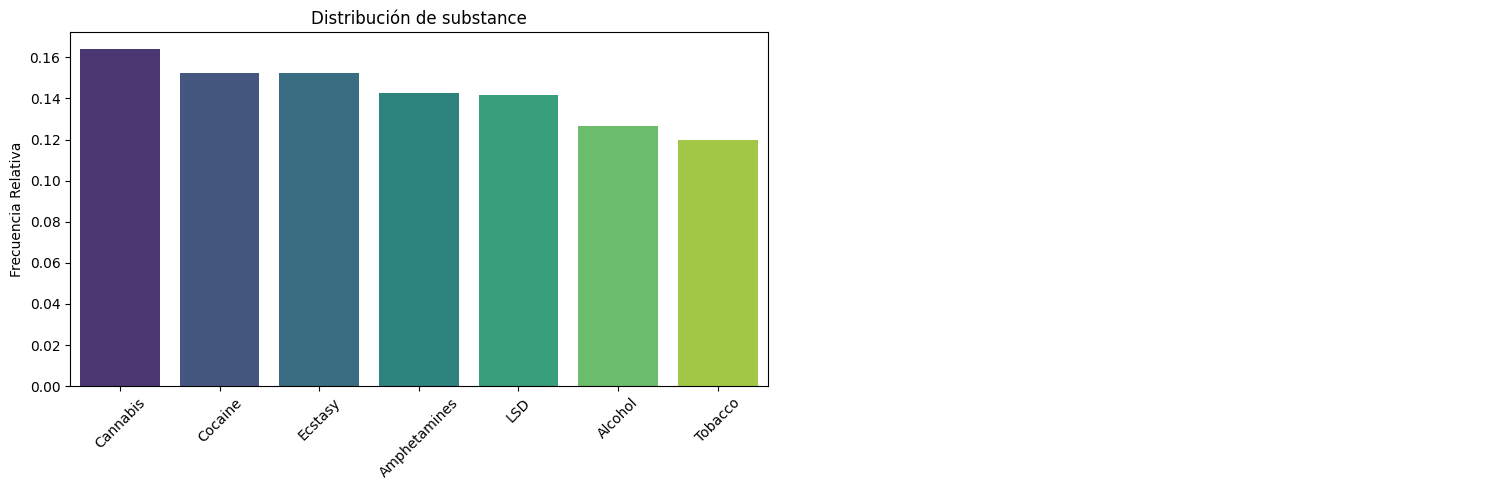

In [128]:
pinta_distribucion_categoricas(df_drugs,["substance"], relativa= True)

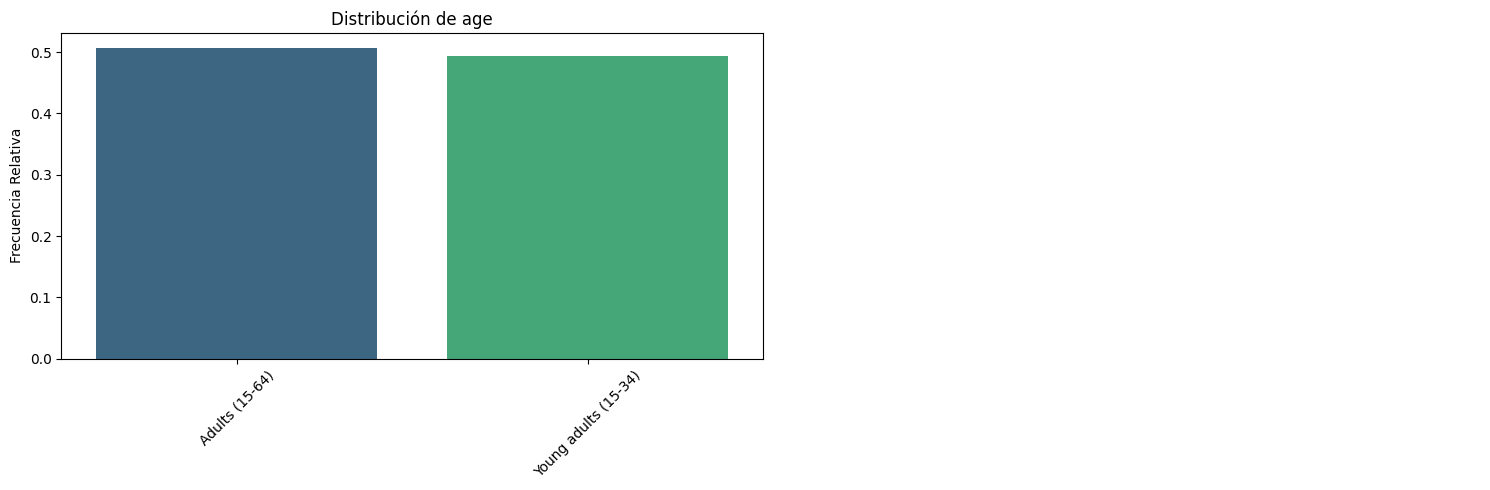

In [129]:
pinta_distribucion_categoricas(df_drugs,["age"], relativa= True)

In [130]:
from scipy.stats import mannwhitneyu

In [161]:
# EDAD - CONSUMO
grupos = df_drugs['age'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.248426192331325
Valor p: 0.6182907188674204


In [160]:
# EDAD - MALES
grupos = df_drugs['age'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['males_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.053066541873767116
Valor p: 0.8178570904383988


In [159]:
# edad - FEMALES
grupos = df_drugs['age'].unique() 

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['age'] == grupo]['females_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 0.2142405250399809
Valor p: 0.6435646389013645


In [162]:
#SUSTANCIA - MALES
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['males_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1290.2007844662353
Valor p: 0.0


In [163]:
#SUSTANCIA - FEMALES
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['females_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 903.5849438036058
Valor p: 0.0


In [166]:
#SUSTANCIA - PREVALENCIA
grupos = df_drugs['substance'].unique()  # ["Adults (15-64)", "Young adults (15-34)"]

# Crear la lista de valores de prevalencia por grupo
prevalencia_por_grupo = [df_drugs[df_drugs['substance'] == grupo]['prevalence_(%)'].dropna() for grupo in grupos]

# ANOVA
f_val, p_val = stats.f_oneway(*prevalencia_por_grupo)

print("Valor F:", f_val)
print("Valor p:", p_val)

Valor F: 1185.687259210663
Valor p: 0.0


## **ANÁLISIS MULTIVARIANTE**